# Applications of Deep Learning in Portfolio Optimisation for Asset Management
**Author:** Haochen Pan

**Date:** 20/04/2024

**Available at https://github.com/derek19990616/Applications_of_Deep_Learning_in_Portfolio_Optimisation_for_Asset_Management**

## Abstract
This study examines the application of deep learning models to enhance portfolio optimisation in asset management. It focuses on the performance of Convolutional Neural Networks (CNN), Temporal Convolutional Networks (TCN), and Long Short-Term Memory networks (LSTM) in forecasting asset price movements. Utilising the Keras Python package, this research employs these models to ascertain the directional trends of daily asset returns as a basis for portfolio optimisation. The evaluation includes an analysis of hyperparameter tuning to establish the most effective model configurations for training.

A key feature of this investigation is the employment of an ensemble approach, blending the predictive capabilities of CNN, TCN, and LSTM models, aiming to refine accuracy and reduce computational efforts. The ensemble model's forecasts serve as the foundation for a dynamic asset allocation strategy, which proposes adjustments to the portfolio in alignment with anticipated market movements. This strategy is geared towards informing whether to adopt long or short positions, with the ultimate aim of achieving optimal portfolio performance.

By mapping out the potential of deep learning models to improve asset management practices, this paper underscores their role in guiding strategic decisions related to asset allocation and portfolio optimisation. The results are intended to illuminate how modelling techniques can be utilised for effective asset distribution, offering pragmatic insights for asset managers keen on integrating predictive analytics into their decision-making processes, especially in the context of portfolio optimisation.

## Imports, Configurations & Random Seeds



In order to view and explore the data, we initially import several Python packages. Additionally, to allow the reader to reproduce our results, we arbitrarily set several random seeds to 100. By setting fixed random seeds, we attempt to minimise the uncertainty introduced by randomness, ensuring consistency and verifiability of the experiments.

In [1]:
# Import essential libraries for mathematical operations, data manipulation, and datetime handling.
import math
import numpy as np
import pandas as pd
import datetime as dt
from pylab import mpl, plt

plt.style.use('seaborn-v0_8')
mpl.rcParams['font.family'] = 'serif'
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

import logging
logging.getLogger('matplotlib.font_manager').disabled = True


pd.set_option('display.float_format', '{:.4f}'.format)
np.set_printoptions(suppress=True, precision=4)
%config InlineBackend.figure_format = 'svg'

In [ ]:
pip install keras-tcn


Note: you may need to restart the kernel to use updated packages.


In [ ]:
pip install quantstats

In [2]:
import tensorflow as tf
import random as rn

# Set seed value
seed = 100
# Set numpy random seed
np.random.seed(seed)
# Set random random seed
rn.seed(seed)
# Set tensorflow random seed
tf.random.set_seed(seed)

We retrieved the data of required tickers from Yahoo Finance, and saved to a CSV file.
We used the 'Manigicent 7' stocks to construct a portfolio.
Each of the so-called Magnificent Seven stocks—Nvidia, Meta, Amazon, Microsoft, Alphabet, Apple and Tesla—performed well in 2023 and powered the broader market higher.



In [3]:
import yfinance as yf
tickers = ['MSFT', 'NVDA', 'AAPL', 'META', 'AMZN', 'GOOGL', 'TSLA']
raw = yf.download(tickers, start='2020-01-01', end='2024-01-11')['Adj Close']
raw.to_csv('stock_data.csv')

[*********************100%%**********************]  7 of 7 completed


In [4]:
raw.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1013 entries, 2020-01-02 to 2024-01-10
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   AAPL    1013 non-null   float64
 1   AMZN    1013 non-null   float64
 2   GOOGL   1013 non-null   float64
 3   META    1013 non-null   float64
 4   MSFT    1013 non-null   float64
 5   NVDA    1013 non-null   float64
 6   TSLA    1013 non-null   float64
dtypes: float64(7)
memory usage: 63.3 KB


Next, we explore the price evolution of 7 tickers over the time period by plotting the last column below.

It can be seen that between 2020 and 2024, the stocks are showing much more divergence in 2024, with Nvidia and Meta continuing to move sharply higher, while Tesla is the biggest decliner so far this year on the S&P 500. 

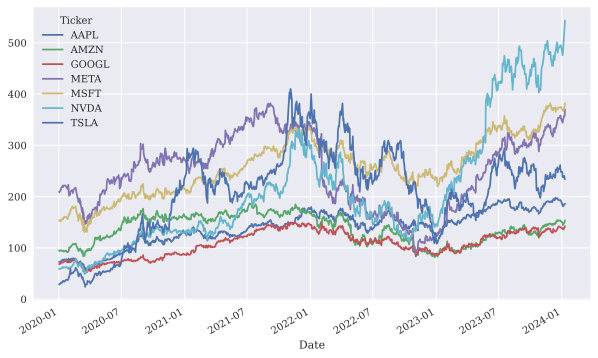

In [5]:
raw.plot(figsize=(10, 6));

In [6]:
# Calculate the logarithmic returns by taking the log of price ratios between consecutive days
data = np.log(raw / raw.shift(1))

# Delete data rows with nan values
data.dropna(inplace=True)
data.head()

Ticker        AAPL    AMZN   GOOGL    META    MSFT    NVDA    TSLA
Date                                                              
2020-01-03 -0.0098 -0.0122 -0.0052 -0.0053 -0.0125 -0.0161  0.0292
2020-01-06  0.0079  0.0148  0.0263  0.0187  0.0026  0.0042  0.0191
2020-01-07 -0.0047  0.0021 -0.0019  0.0022 -0.0092  0.0120  0.0381
2020-01-08  0.0160 -0.0078  0.0071  0.0101  0.0158  0.0019  0.0480
2020-01-09  0.0210  0.0048  0.0104  0.0142  0.0124  0.0109 -0.0222

To inspect the distribution of the log returns, r, we make use of the scipy package. Below, a frequency distribution of the log returns, r, is plotted. A normal distribution is plotted for comparison.

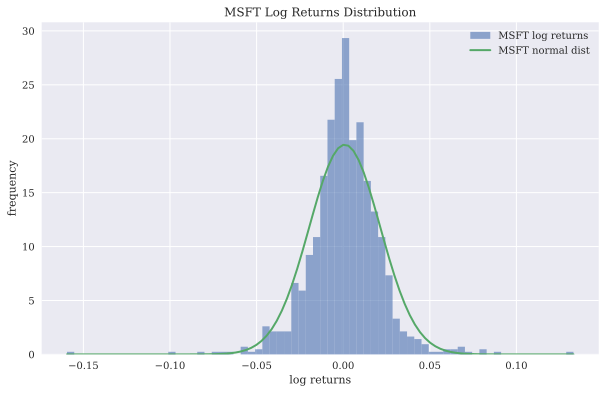

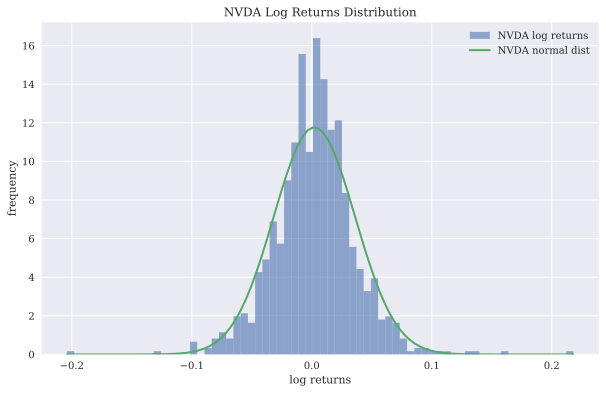

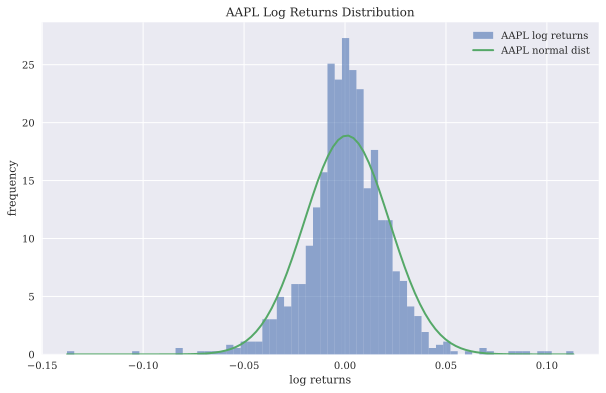

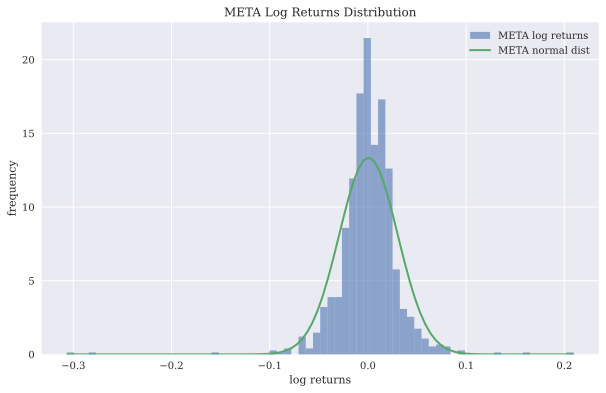

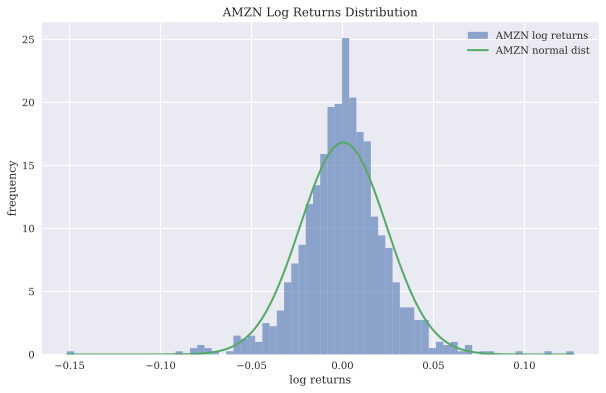

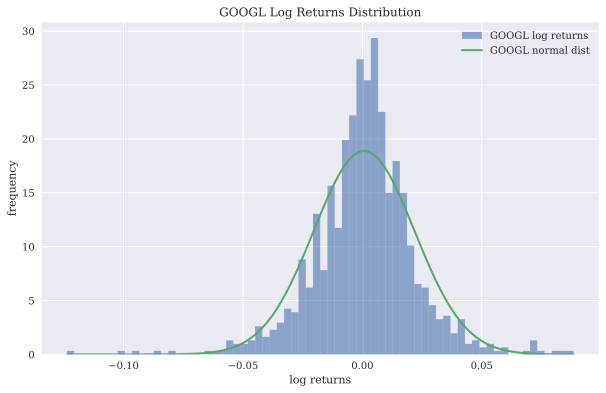

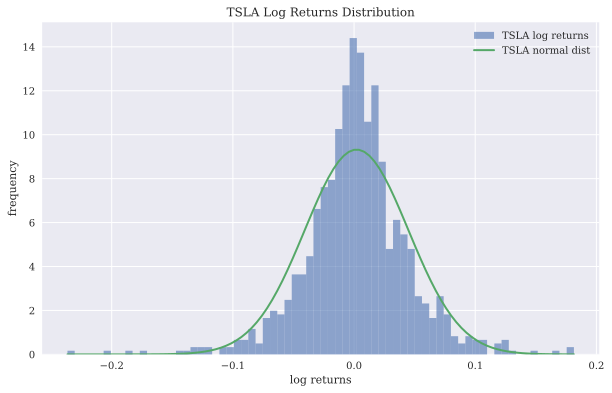

In [7]:
import scipy.stats as scs


# Loop through each ticker to create and plot their distributions separately
for ticker in tickers:
    # Set up the figure for plotting each ticker individually
    plt.figure(figsize=(10, 6))
    
    # Select the log returns for the current ticker
    ticker_rets = data[ticker]
    
    # Plot histogram for the ticker
    plt.hist(ticker_rets, bins=70, density=True, alpha=0.6, label=f'{ticker} log returns')
    
    # Fit a normal distribution to the ticker's log returns
    x = np.linspace(min(ticker_rets), max(ticker_rets), 100)
    plt.plot(x, scs.norm.pdf(x, ticker_rets.mean(), ticker_rets.std()), lw=2.0, label=f'{ticker} normal dist')
    
    # Name x axis
    plt.xlabel('log returns')
    
    # Name y axis
    plt.ylabel('frequency')
    
    # Add title with the ticker name
    plt.title(f'{ticker} Log Returns Distribution')
    
    # Display legend
    plt.legend()
    
    # Show the plot for this ticker
    plt.show()


MSFT (Microsoft Corporation): The histogram suggests a concentration of log returns around zero with a slight right skew.
NVDA (NVIDIA Corporation): This histogram also clusters around zero but with evidence of a sharper peak and potential fat tails, indicating a leptokurtic distribution.
AAPL (Apple Inc.): Similar to MSFT, this histogram shows a unimodal distribution with a modest skew to the right.
META (Meta Platforms, Inc.): The histogram shows a wide spread of returns, again with a peak near zero and a slight positive skew.
AMZN (Amazon.com, Inc.): This asset’s returns are tightly clustered, with a notable peak indicating higher frequency of smaller magnitude returns.
GOOGL (Alphabet Inc.): The distribution of returns shows a central peak, with log returns symmetrically distributed about the mean.
TSLA (Tesla, Inc.): The histogram for Tesla's log returns displays a pronounced peak and suggests a leptokurtic distribution with possible outliers or extreme values.


To investigate further, we use the statsmodels package to create a Q-Q plot of the log returns, r.



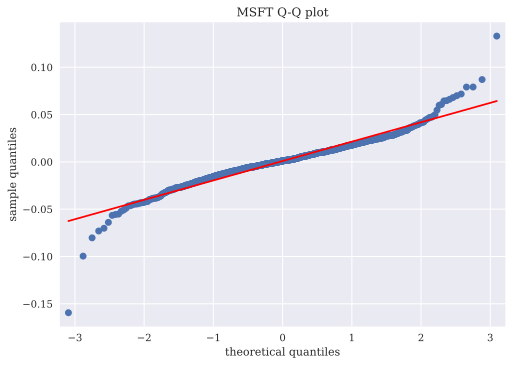

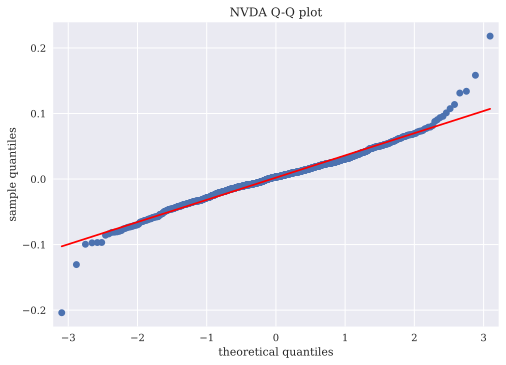

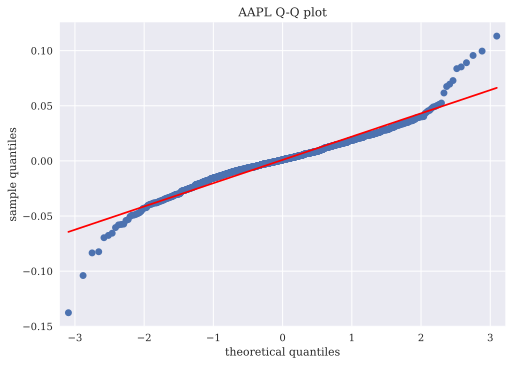

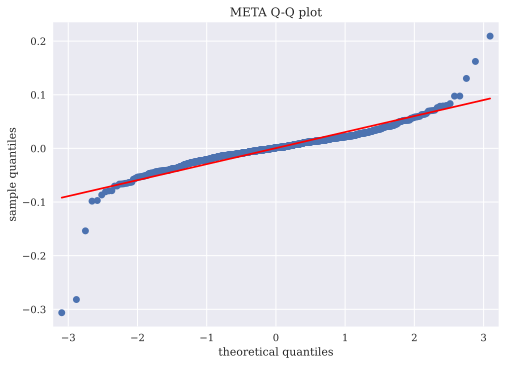

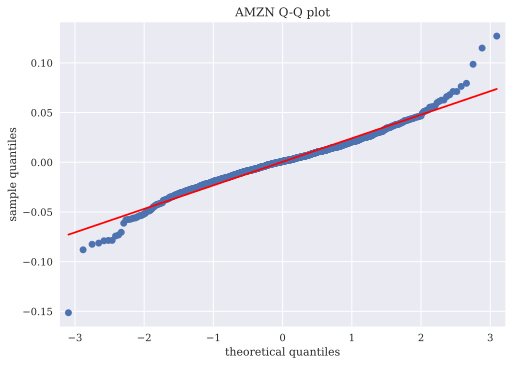

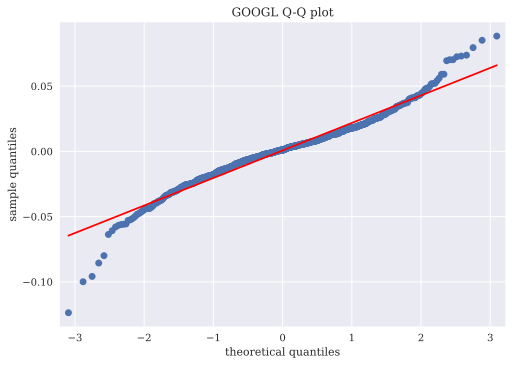

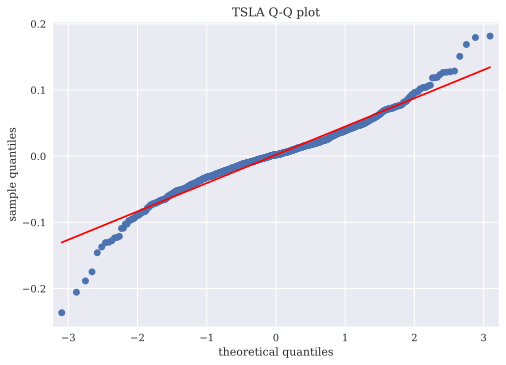

In [8]:
import statsmodels.api as sm
for ticker in tickers:
    # Create Q-Q plot for the ticker
    sm.qqplot(data[ticker], line='s')
    
    # Add title with the ticker name
    plt.title(f'{ticker} Q-Q plot')
    
    # Name x axis
    plt.xlabel('theoretical quantiles')
    
    # Name y axis
    plt.ylabel('sample quantiles')
    
    # Show the plot
    plt.show()


We first extract the relevant dates from our dataset to match the predictions made by the model. These dates are then used to index a new DataFrame, which we populate with the predicted return values for each ticker. This approach results in a structured presentation of the predictions, enabling us to easily review the financial returns predicted by the model for each asset by date.

In [9]:

# Define the number of lags (past periods) to create
lags = 3

# Function to create lagged features for each column in a DataFrame
def create_lags(rets):
    cols = []  # Initialize a list to store the names of the new lag columns
    
    # Iterate over each column in the DataFrame
    for sym in rets.columns:
        # For each column, generate up to 'lags' lagged features
        for lag in range(1, lags + 1):
            # Create a new column name for each lag
            col = f'{sym}_lag_{lag}'
            # Shift the data in the column down by 'lag' places; this creates the lagged feature
            rets[col] = rets[sym].shift(lag)
            # Append the new column name to the list
            cols.append(col)
    # Return a list of all created column names
    return cols


In [10]:
cols = create_lags(data)


In [11]:
data.dropna(inplace=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1009 entries, 2020-01-08 to 2024-01-10
Data columns (total 28 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   AAPL         1009 non-null   float64
 1   AMZN         1009 non-null   float64
 2   GOOGL        1009 non-null   float64
 3   META         1009 non-null   float64
 4   MSFT         1009 non-null   float64
 5   NVDA         1009 non-null   float64
 6   TSLA         1009 non-null   float64
 7   AAPL_lag_1   1009 non-null   float64
 8   AAPL_lag_2   1009 non-null   float64
 9   AAPL_lag_3   1009 non-null   float64
 10  AMZN_lag_1   1009 non-null   float64
 11  AMZN_lag_2   1009 non-null   float64
 12  AMZN_lag_3   1009 non-null   float64
 13  GOOGL_lag_1  1009 non-null   float64
 14  GOOGL_lag_2  1009 non-null   float64
 15  GOOGL_lag_3  1009 non-null   float64
 16  META_lag_1   1009 non-null   float64
 17  META_lag_2   1009 non-null   float64
 18  META_lag_3   1009 non-null   f

In [12]:
data[cols] = (data[cols] - data[cols].mean()) / data[cols].std()


A critical part of any machine learning study is to have a clear distinction between the data that is used to train a model and the data used to evaluate the predictive power of the model out-of-sample. Therefore, we will split our data into 3 sections.

train: 80% of data will be used for training the models
val: 15% of train will be used to validate the performance of the models during the training stages
test: 20% of data will be used to evaluate the performance of the models out-of-sample


In [13]:
# 80% train/test split
split = int(len(data) * 0.8)
# 15% validation partition
val_size = int(split * 0.15)
# Create train data set
train = data.iloc[:split]


We initially copy the first 80% of the dataset to form our preliminary training dataset.
From this training subset, we extract the last 15% to form the validation set, which is crucial for tuning the model parameters during training.
After extracting the validation data, we adjust the training set to exclude the validation portion.
Finally, the remaining 20% of the original dataset is set aside as the test dataset. This is used to evaluate the model's performance on data it has never seen, providing insights into the model's generalisability and out-of-sample predictive power.

In [14]:
# Train data prior to validation split
train = data.iloc[:split].copy()
# Validation data
val = train[-val_size:]
# Train data after validation split
train = train[:-val_size]
# Test data
test = data.iloc[split:].copy()

We reshape the training, validation, and test datasets (X_train, X_val, X_test) to match the input structure required by our neural networks, ensuring each set has dimensions suitable for model processing. This reshaping facilitates the handling of feature sets within the network layers.

In [15]:
X_train = train[cols].values.reshape((-1, 1, len(cols)))
X_val = val[cols].values.reshape((-1, 1, len(cols)))
X_test = test[cols].values.reshape((-1, 1, len(cols)))


Preparing Target Variables for Model Training and Evaluation:

Training and Validation Targets: For both the training and validation sets (y_train and y_val), we shift the data by one position to obtain future values as labels, removing the last entry as it lacks a subsequent value to serve as a label.
Testing Targets: The test set (y_test) is similarly shifted to align future values as labels; however, we retain the last row since immediate prediction performance on this unseen data is critical.
Reshape for Compatibility: All target variables are converted to arrays to ensure they are in the correct format for processing by the neural network models.

In [16]:
# For the training data, we still need to remove the last row, as it does not have a future value to serve as a label
y_train = train[tickers].shift(-1)
y_val = val[tickers].shift(-1)
y_test = test[tickers].shift(-1)  

# Ensure that the target variables are also in the correct shape.
y_train = y_train.values
y_val = y_val.values
y_test = y_test.values


In [17]:
means = np.nanmean(y_train, axis=0)
# we use the mean value to fill NaN 
y_train = np.where(np.isnan(y_train), means, y_train)

y_train_means = np.nanmean(y_train, axis=0)
# we use the mean value to fill NaN 
y_val = np.where(np.isnan(y_val), y_train_means, y_val)
y_test_means = np.nanmean(y_test, axis=0)

# we use the mean value to fill NaN 
y_test = np.where(np.isnan(y_test), y_test_means, y_test)
print("Train shapes:", X_train.shape, y_train.shape)
print("Validation shapes:", X_val.shape, y_val.shape)
print("Test shapes:", X_test.shape, y_test.shape)
# check if there is any null value
print("NaN in X_train:", np.isnan(X_train).any())
print("Inf in X_train:", np.isinf(X_train).any())
print("NaN in y_train:", np.isnan(y_train).any())
print("Inf in y_train:", np.isinf(y_train).any())
print("NaN in X_test:", np.isnan(X_test).any())
print("Inf in X_test:", np.isinf(X_test).any())
print("NaN in y_test:", np.isnan(y_test).any())
print("Inf in y_test:", np.isinf(y_test).any())
print("NaN in X_val:", np.isnan(X_val).any())
print("Inf in X_val:", np.isinf(X_val).any())
print("NaN in y_val:", np.isnan(y_val).any())
print("Inf in y_val:", np.isinf(y_val).any())



Train shapes: (686, 1, 21) (686, 7)
Validation shapes: (121, 1, 21) (121, 7)
Test shapes: (202, 1, 21) (202, 7)
NaN in X_train: False
Inf in X_train: False
NaN in y_train: False
Inf in y_train: False
NaN in X_test: False
Inf in X_test: False
NaN in y_test: False
Inf in y_test: False
NaN in X_val: False
Inf in X_val: False
NaN in y_val: False
Inf in y_val: False


We created the helper functions of portfolio variance and volatility.
For portfolio_varience we scaled up to an annual measure by multiplying it by 252, which is the typical number of trading days in a year.

In [18]:
def portfolio_variance(weights, rets):
    return np.dot(weights.T, np.dot(rets.cov(), weights)) * 252

def portfolio_volatility(weights, rets):
    return math.sqrt(portfolio_variance(weights, rets))

## CNN Model Architecture and Training for Asset Return Prediction
This analysis utilises an advanced Convolutional Neural Network (CNN) to forecast the return rates of various assets, employing the Keras library with TensorFlow as the backend. The approach adopts sophisticated deep learning techniques tailor-made for the complexities of quantitative finance.

# Model Building:
Initialisation:

A Sequential model is initialised, facilitating a layer-by-layer assembly that provides a structured approach to incorporating convolutional, normalisation, and dense layers.
Core Layers:

Convolutional Layer: The initial layer is a 1D convolutional layer, equipped with a designated number of filters and kernel size. It is designed to process temporal sequences by capturing features across the time dimension efficiently.
Batch Normalisation: Follows each convolutional deployment to standardise activations, thereby helping to stabilise and expedite the training phase.
Dropout: Implemented conditionally to mitigate overfitting by randomly disabling a portion of the feature detectors during training.
Flattening and Dense Layers:

Outputs from convolutional stages are flattened, transforming the 2D feature maps into a 1D vector that feeds into subsequent dense layers.
A dense layer featuring 50 neurons utilises 'relu' activation to introduce non-linearity, culminating in a final output layer tailored to predict continuous asset returns without any activation function.
# Model Compilation and Optimisation:
Optimizer: An Adam optimiser with a deliberately reduced learning rate is employed, allowing for meticulous adjustments aimed at minimising the mean squared error (MSE).
Loss Function: The MSE is selected to align the model’s training objectives with minimising prediction errors for asset returns.
#Parameter Tuning and Model Training:
Parameter Grid Search: A comprehensive exploration across a predefined grid of hyperparameters (filters, kernel size, dropout rates, hidden layers) is conducted to identify the optimal settings. This procedure iterates over various combinations, evaluating each model configuration based on validation loss and accuracy.
Performance Monitoring: The training is monitored using an EarlyStopping callback, which terminates the process when no further improvements in validation loss are observed, ensuring computational efficiency and preventing over-training.
Optimal Parameters Selection: The selection of the best model parameters is determined by continuously comparing the current models against the best observed validation loss and accuracy. This ensures that the most effective model configuration is adopted.
# Evaluation and Practical Application:
Predictive Performance: Post-training, the model’s efficacy is assessed on a separate test set, initially inspecting a subset of predictions to verify operational accuracy.
Metrics Calculation: Performance metrics such as MSE and accuracy for each asset are computed to quantitatively evaluate prediction accuracy.
Financial Metrics and Optimisation: Predictions from the model are subsequently utilised in financial scenarios like portfolio optimisation, where constraints are applied to maximise financial returns based on predictive insights.
This detailed exposition underscores the utilisation of CNNs in financial analytics, highlighting the sophisticated deep learning techniques and systematic parameter optimisation approach employed to manage and predict complex financial time series data effectively.



In [19]:
from keras.models import Sequential
from keras.layers import Conv1D, Flatten, Dense, Dropout, BatchNormalization
from keras.optimizers import Adam
import keras.backend as K
from keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import mean_squared_error, accuracy_score

# Function to calculate custom accuracy based on a threshold
def reg_accuracy(y_true, y_pred, threshold=0.1):
    return K.mean(K.less_equal(K.abs(y_true - y_pred), threshold), axis=-1)

# Function to build a CNN model with configurable parameters
def build_cnn(input_shape, filters, kernel_size, dropout_rate, hidden_layers, output_units=7):
    model = Sequential(name='CNN_Model')
    # Add a convolutional layer with specified number of filters and kernel size
    model.add(Conv1D(filters=filters, kernel_size=kernel_size, activation='relu', input_shape=input_shape, padding='same'))
    # Add batch normalization to normalize the activations of the previous layer
    model.add(BatchNormalization())
    # Optionally add dropout to reduce overfitting
    if dropout_rate > 0:
        model.add(Dropout(rate=dropout_rate))

    # Add additional convolutional layers based on the number of hidden layers specified
    for _ in range(1, hidden_layers):
        model.add(Conv1D(filters=filters, kernel_size=kernel_size, activation='relu', padding='same'))
        model.add(BatchNormalization())
        if dropout_rate > 0:
            model.add(Dropout(rate=dropout_rate))

    # Flatten the output of the convolutions to make it suitable for input to a dense layer
    model.add(Flatten())
    # Add a fully connected layer with 50 neurons
    model.add(Dense(50, activation='relu'))
    model.add(BatchNormalization())
    if dropout_rate > 0:
        model.add(Dropout(rate=dropout_rate))
    # Output layer with a number of units equal to the number of output variables
    model.add(Dense(output_units, activation='linear'))

    # Define the optimizer with a specified learning rate, compile the model with mean squared error loss
    optimizer = Adam(learning_rate=0.0001)
    model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mean_squared_error', reg_accuracy])
    
    return model


In [20]:
import itertools
from tensorflow.keras.callbacks import EarlyStopping
import numpy as np

 # hyperparameter tuning, finding the best parameter.
"""

# Dictionary containing the parameter options for the CNN
param_grid = {
    'filters': [16, 32, 64, 128, 256],  # Number of filters in the conv layers
    'kernel_size': [2, 3],  # Size of the kernel to use in each conv layer
    'dropout_rate': [0.2, 0.3, 0.4],  # Dropout rate to prevent overfitting
    'hidden_layers': [2, 3, 4]  # Number of hidden conv layers in the network
}

# Variables to store the best model, its loss, and parameters
best_model = None
best_loss = float('inf')
best_params = {}

# Iterates over every combination of parameters in the grid
for params in itertools.product(*param_grid.values()):
    param_dict = dict(zip(param_grid.keys(), params))  # Create a parameter dictionary
    print("Testing configuration:", param_dict)
    try:
        # Build CNN model with the current set of parameters
        cnn_model = build_cnn(input_shape=(1, len(tickers)*lags), output_units=len(tickers), **param_dict)
        
        # Setup early stopping to prevent overfitting
        early_stopping_monitor = EarlyStopping(monitor='val_loss', patience=10, verbose=1, restore_best_weights=True)
        
        # Fit the model
        cnn_model.fit(
            X_train, y_train, 
            epochs=1000,  # Large number of epochs, controlled by early stopping
            batch_size=32, 
            verbose=1, 
            validation_data=(X_val, y_val), 
            callbacks=[early_stopping_monitor]
        )
        val_loss = cnn_model.evaluate(X_val, y_val, verbose=0)[0]  # Evaluate the model on the validation set
        
        # Update the best model if the current model has a lower validation loss
        if val_loss < best_loss:
            best_loss = val_loss
            best_model = cnn_model
            best_params = param_dict
            print(f"New best model found: {param_dict} with validation loss: {val_loss:.4f}")
    except Exception as e:
        print(f"Failed to build or train model with parameters {param_dict} due to error: {e}")

# Output the best model parameters and its validation loss
print(f"Best model parameters: {best_params} with validation loss: {best_loss:.4f}")


"""



'\n\n# Dictionary containing the parameter options for the CNN\nparam_grid = {\n    \'filters\': [16, 32, 64, 128, 256],  # Number of filters in the conv layers\n    \'kernel_size\': [2, 3],  # Size of the kernel to use in each conv layer\n    \'dropout_rate\': [0.2, 0.3, 0.4],  # Dropout rate to prevent overfitting\n    \'hidden_layers\': [2, 3, 4]  # Number of hidden conv layers in the network\n}\n\n# Variables to store the best model, its loss, and parameters\nbest_model = None\nbest_loss = float(\'inf\')\nbest_params = {}\n\n# Iterates over every combination of parameters in the grid\nfor params in itertools.product(*param_grid.values()):\n    param_dict = dict(zip(param_grid.keys(), params))  # Create a parameter dictionary\n    print("Testing configuration:", param_dict)\n    try:\n        # Build CNN model with the current set of parameters\n        cnn_model = build_cnn(input_shape=(1, len(tickers)*lags), output_units=len(tickers), **param_dict)\n        \n        # Setup early

In [21]:
"""
cnn_model = build_cnn(
    input_shape=(1, len(tickers)*lags),  
    output_units=len(tickers),  
    filters=best_params['filters'],
    kernel_size=best_params['kernel_size'],
    dropout_rate=best_params['dropout_rate'],
    hidden_layers=best_params['hidden_layers']
)
"""
# we used assigned parameter insteads to save runing time. Or unhide the above section and use the automation hyperparameter tuning part
cnn_model = build_cnn(
    input_shape=(1, len(tickers)*lags),  
    output_units=len(tickers),  
    filters=16,
    kernel_size=3,
    dropout_rate=0.4,
    hidden_layers=4
) 



early_stopping_monitor = EarlyStopping(
    monitor='val_loss',    # The metric to monitor, here it is the validation set loss
    patience=10,           # Stop after 10 epochs with no improvement
    verbose=1,             # Log printing
    restore_best_weights=True  # Restore the model weights from the epoch with the best value of the monitored quantity
)

# Train the model using early stopping
cnn_model.fit(
    X_train, y_train,
    epochs=1000,  # A large number, but usually controlled by early stopping
    batch_size=32,
    verbose=1,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping_monitor]  # Pass early stopping as a callback function
)

# Evaluate the model
test_loss, test_mse, test_accuracy = cnn_model.evaluate(X_test, y_test, verbose=1)
print(f"Test MSE: {test_mse:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Loss: {test_loss:.4f}")


Epoch 1/1000
22/22 [==============================] - 2s 19ms/step - loss: 3.1163 - mean_squared_error: 3.1163 - reg_accuracy: 0.0591 - val_loss: 0.0048 - val_mean_squared_error: 0.0048 - val_reg_accuracy: 0.8772
Epoch 2/1000
22/22 [==============================] - 0s 6ms/step - loss: 3.0553 - mean_squared_error: 3.0553 - reg_accuracy: 0.0562 - val_loss: 0.0142 - val_mean_squared_error: 0.0142 - val_reg_accuracy: 0.5183
Epoch 3/1000
22/22 [==============================] - 0s 6ms/step - loss: 2.8597 - mean_squared_error: 2.8597 - reg_accuracy: 0.0579 - val_loss: 0.0254 - val_mean_squared_error: 0.0254 - val_reg_accuracy: 0.2987
Epoch 4/1000
22/22 [==============================] - 0s 6ms/step - loss: 3.0062 - mean_squared_error: 3.0062 - reg_accuracy: 0.0575 - val_loss: 0.0382 - val_mean_squared_error: 0.0382 - val_reg_accuracy: 0.1865
Epoch 5/1000
22/22 [==============================] - 0s 6ms/step - loss: 2.6908 - mean_squared_error: 2.6908 - reg_accuracy: 0.0554 - val_loss: 0.0493

In [22]:
cnn_model.save('best_cnn_model.h5')
cnn_pred = cnn_model.predict(X_test)
print(cnn_pred[:5])  # Display first 5 predictions



7/7 [==============================] - 0s 0s/step
[[-0.0431 -0.0534  0.0555 -0.0599  0.0833  0.0493 -0.0432]
 [-0.0499 -0.0574  0.0421 -0.0807  0.0844  0.0351 -0.0745]
 [-0.0494 -0.058   0.0414 -0.0794  0.0814  0.031  -0.0762]
 [-0.0374 -0.0459  0.0442 -0.0553  0.0864  0.0447 -0.0634]
 [-0.0453 -0.0575  0.0436 -0.0798  0.0803  0.0394 -0.0613]]


we handle the preparation, training, and prediction stages of our CNN model to forecast financial returns. We start by reshaping the feature set and splitting the data into training, validation, and test sets. The model is then trained using the specified parameters, and subsequently, we use it to predict future returns on unseen test data. This process helps us validate the model’s effectiveness in predicting financial metrics based on historical data.

In [23]:
prediction_dates = data.index[-len(cnn_pred):]  
predicted_returns = pd.DataFrame(cnn_pred, index=prediction_dates, columns=tickers)
predicted_returns.head()

MSFT    NVDA   AAPL    META   AMZN  GOOGL    TSLA
Date                                                           
2023-03-23 -0.0431 -0.0534 0.0555 -0.0599 0.0833 0.0493 -0.0432
2023-03-24 -0.0499 -0.0574 0.0421 -0.0807 0.0844 0.0351 -0.0745
2023-03-27 -0.0494 -0.0580 0.0414 -0.0794 0.0814 0.0310 -0.0762
2023-03-28 -0.0374 -0.0459 0.0442 -0.0553 0.0864 0.0447 -0.0634
2023-03-29 -0.0453 -0.0575 0.0436 -0.0798 0.0803 0.0394 -0.0613

In [24]:
predicted_returns.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 202 entries, 2023-03-23 to 2024-01-10
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   MSFT    202 non-null    float32
 1   NVDA    202 non-null    float32
 2   AAPL    202 non-null    float32
 3   META    202 non-null    float32
 4   AMZN    202 non-null    float32
 5   GOOGL   202 non-null    float32
 6   TSLA    202 non-null    float32
dtypes: float32(7)
memory usage: 7.1 KB


In [25]:
true_returns = data.loc[predicted_returns.index, tickers]

# Calculate the MSE for the portfolio
mse = mean_squared_error(true_returns, predicted_returns)
mse

0.004186099553828035

In [26]:
# Calculate the MSE for each ticker

for ticker in tickers:
    mse = mean_squared_error(true_returns[ticker], predicted_returns[ticker])
    print(f'{ticker}: MSE={mse}')

MSFT: MSE=0.0022597375253730102
NVDA: MSE=0.00371413452839938
AAPL: MSE=0.0017697226400691904
META: MSE=0.0065077968526287755
AMZN: MSE=0.007168415234101163
GOOGL: MSE=0.0015862356231482835
TSLA: MSE=0.006296654473076429


In [27]:
for ticker in tickers:
    acc = accuracy_score(np.sign(true_returns[ticker]), np.sign(predicted_returns[ticker]))
    print(f'{ticker}: ACC={acc}')

MSFT: ACC=0.4405940594059406
NVDA: ACC=0.44554455445544555
AAPL: ACC=0.5346534653465347
META: ACC=0.4504950495049505
AMZN: ACC=0.5495049504950495
GOOGL: ACC=0.5396039603960396
TSLA: ACC=0.4801980198019802


In [28]:
strat_cnn = np.sign(predicted_returns) * true_returns[tickers]
strat_cnn.head()

MSFT    NVDA    AAPL    META    AMZN   GOOGL    TSLA
Date                                                              
2023-03-23 -0.0195 -0.0269  0.0069 -0.0221  0.0001  0.0213 -0.0056
2023-03-24 -0.0104  0.0153  0.0083 -0.0084 -0.0059 -0.0015  0.0095
2023-03-27  0.0150  0.0093 -0.0124  0.0155 -0.0009 -0.0287 -0.0073
2023-03-28  0.0042  0.0046 -0.0040  0.0107 -0.0082 -0.0141  0.0138
2023-03-29 -0.0190 -0.0215  0.0196 -0.0230  0.0305  0.0036 -0.0245

<Axes: xlabel='Date'>

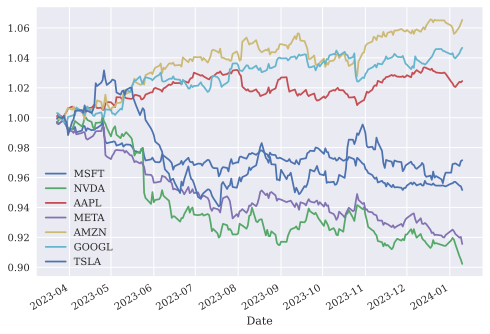

In [29]:
weights = len(tickers) * [1 / len(tickers)]
(weights*strat_cnn).cumsum().apply(np.exp).plot()


                           Strategy
-------------------------  ----------
Start Period               2023-03-23
End Period                 2024-01-10
Risk-Free Rate             0.0%
Time in Market             100.0%

Cumulative Return          -13.19%
CAGR﹪                     -11.45%

Sharpe                     -1.51
Prob. Sharpe Ratio         8.33%
Smart Sharpe               -1.35
Sortino                    -1.92
Smart Sortino              -1.72
Sortino/√2                 -1.36
Smart Sortino/√2           -1.22
Omega                      0.78

Max Drawdown               -16.75%
Longest DD Days            260
Volatility (ann.)          11.27%
Calmar                     -0.68
Skew                       -0.6
Kurtosis                   3.59

Expected Daily %           -0.07%
Expected Monthly %         -1.28%
Expected Yearly %          -6.83%
Kelly Criterion            -13.74%
Risk of Ruin               0.0%
Daily Value-at-Risk        -1.24%
Expected Shortfall (cVaR)  -1.24%

Max Consecuti

None

Start      Valley         End  Days  Max Drawdown  99% Max Drawdown
1  2023-04-26  2023-07-18  2024-01-10   260      -16.7486          -15.7519
2  2023-03-27  2023-03-31  2023-04-04     9       -1.6259           -0.8707
3  2023-04-17  2023-04-18  2023-04-19     3       -0.8054           -0.5998
4  2023-04-10  2023-04-11  2023-04-12     3       -0.6679           -0.5208

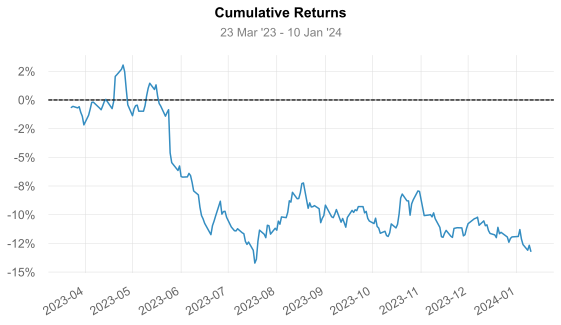

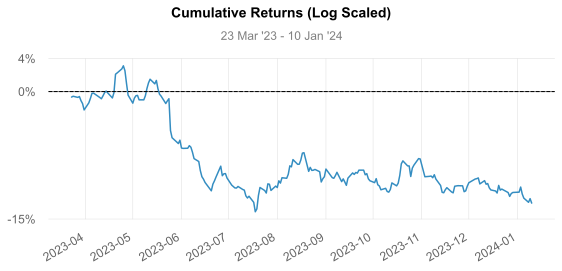

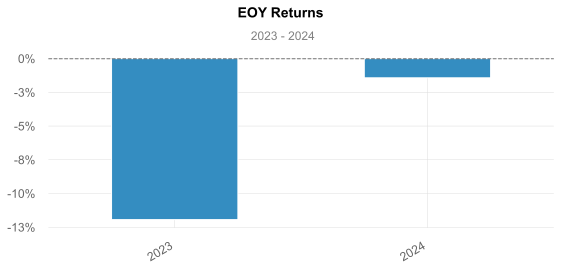

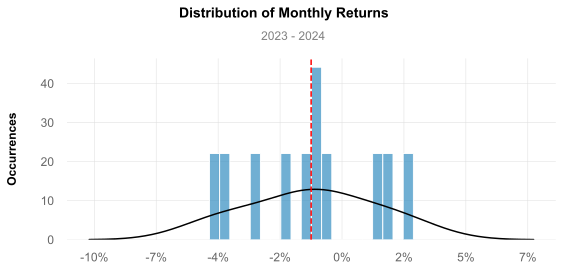

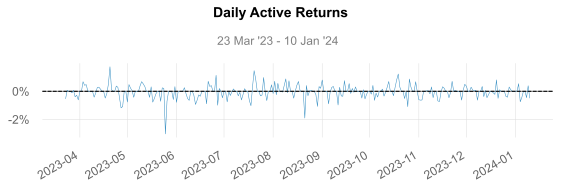

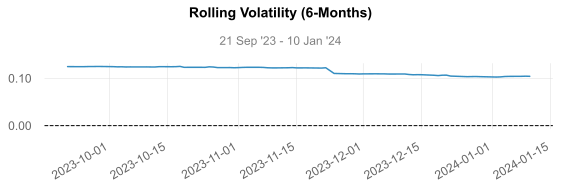

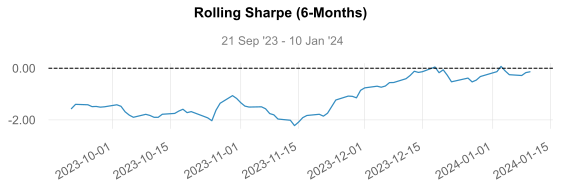

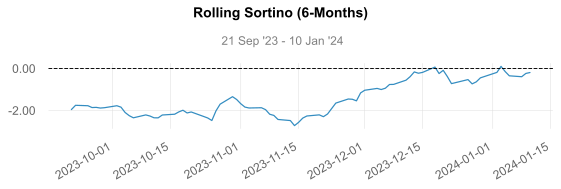

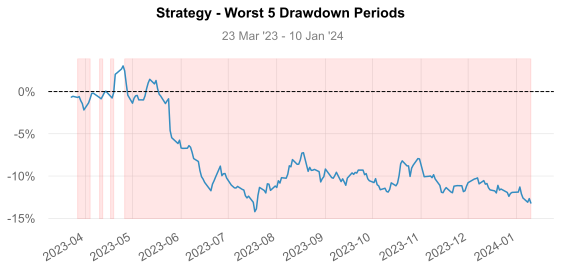

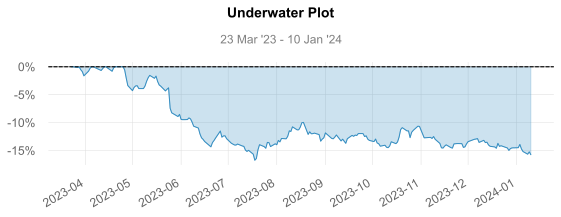

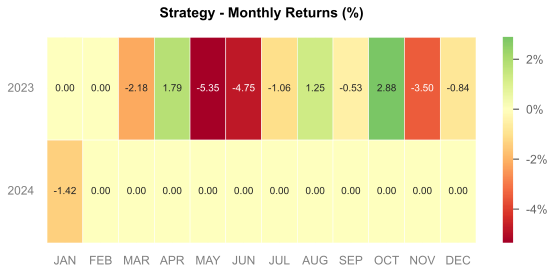

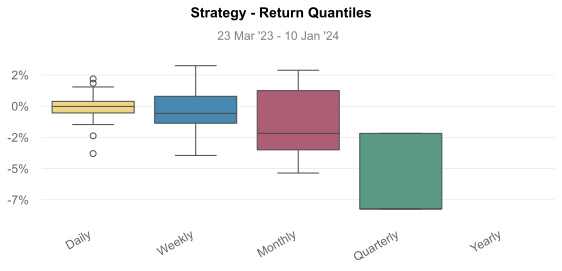

In [30]:
# display the perfoemance through quantstats
import quantstats as qs

cnn_portfolio_cumulative_returns = (strat_cnn*weights).sum(axis=1)
cnn_daily_returns = cnn_portfolio_cumulative_returns.fillna(0)

qs.extend_pandas()
qs.reports.full(cnn_daily_returns)

The CNN model's weighted-average performance over the observed period shows a cumulative negative return, indicating an overall loss in the strategy. The key metrics show a negative Sharpe ratio, suggesting that the risk-adjusted return of the strategy underperforms the risk-free rate. The maximum drawdown and volatility are significant, further reflecting a higher risk profile. The monthly and quarterly win rates are mixed, with some periods of gains overshadowed by periods of losses. Overall, the strategy faced challenges in delivering consistent positive returns, as evidenced by the predominantly downward trend in cumulative returns and the distribution of monthly returns showing variability in performance.








In [31]:
from scipy.optimize import minimize

bnds = len(tickers) * [(-1, 1)]
cons = {'type': 'eq', 'fun': lambda weights: weights.sum() - 1}

In [32]:
# ensure weight has the same data structure
w_cnn = predicted_returns.copy()


In [33]:
#defining the sharpe ration function
def sharpe(weights, r, re):
    port_ret = np.dot(r, weights)
    port_vol = portfolio_volatility(weights, re)
    return port_ret / port_vol

In [34]:
%%time
for pred in predicted_returns.iloc[:].iterrows():
    r = pred[1].values * 252
    re = predicted_returns.loc[:pred[0]][tickers]
    opt = minimize(lambda w_cnn: -sharpe(w_cnn, r=r, re=re),
                  np.ones(len(tickers)), bounds=bnds,
                         constraints=cons)
    w_cnn.loc[pred[0]] = opt['x']

opt['x']


CPU times: total: 9.38 s
Wall time: 11.4 s


array([ 0.1803, -0.434 ,  0.6939, -0.2822,  0.8411,  0.5013, -0.5004])

<Axes: xlabel='Date'>

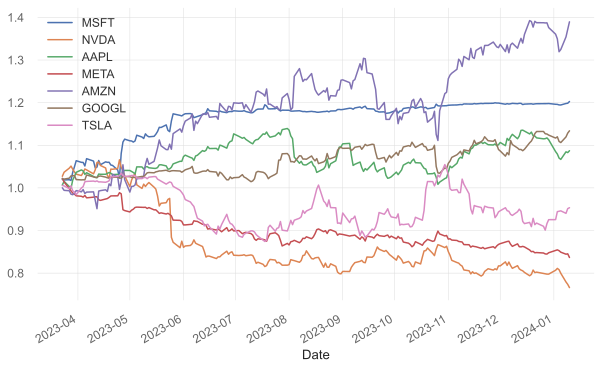

In [35]:
#optimisd weighted portfolio
strat_cnn_optimum = w_cnn * true_returns.loc[w_cnn.index[0]:][tickers]
strat_cnn_optimum.dropna(inplace=True)


strat_cnn_optimum.cumsum().apply(np.exp).plot()


                           Strategy
-------------------------  ----------
Start Period               2023-03-23
End Period                 2024-01-10
Risk-Free Rate             0.0%
Time in Market             100.0%

Cumulative Return          19.43%
CAGR﹪                     16.5%

Sharpe                     0.79
Prob. Sharpe Ratio         76.06%
Smart Sharpe               0.74
Sortino                    1.17
Smart Sortino              1.09
Sortino/√2                 0.82
Smart Sortino/√2           0.77
Omega                      1.15

Max Drawdown               -20.25%
Longest DD Days            204
Volatility (ann.)          36.33%
Calmar                     0.81
Skew                       0.15
Kurtosis                   2.95

Expected Daily %           0.09%
Expected Monthly %         1.63%
Expected Yearly %          9.29%
Kelly Criterion            6.84%
Risk of Ruin               0.0%
Daily Value-at-Risk        -3.65%
Expected Shortfall (cVaR)  -3.65%

Max Consecutive Wins       

None

Start      Valley         End  Days  Max Drawdown  99% Max Drawdown
1  2023-05-17  2023-10-05  2023-12-06   204      -20.2505          -19.5000
2  2023-04-28  2023-05-01  2023-05-10    13       -9.9475           -7.2974
3  2023-12-08  2024-01-05  2024-01-10    34       -9.6904           -8.3112
4  2023-04-10  2023-04-12  2023-04-12     3       -5.4795           -5.2775
5  2023-04-24  2023-04-25  2023-04-25     2       -3.5283           -1.1663

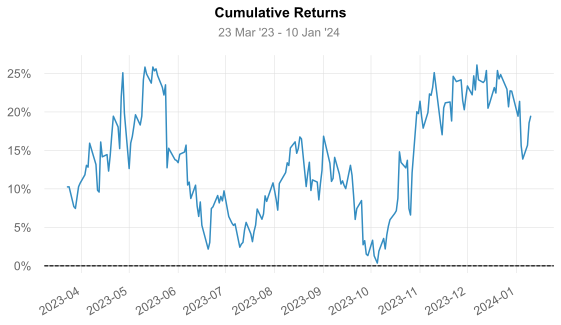

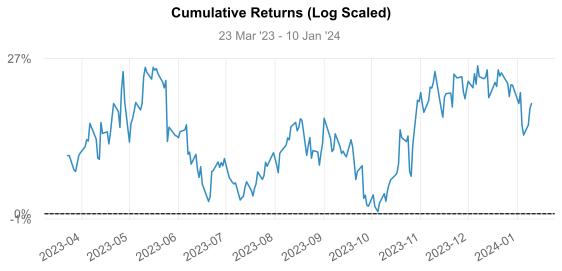

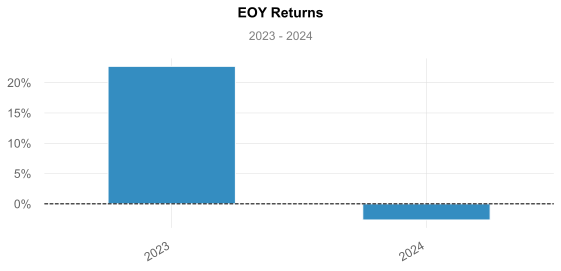

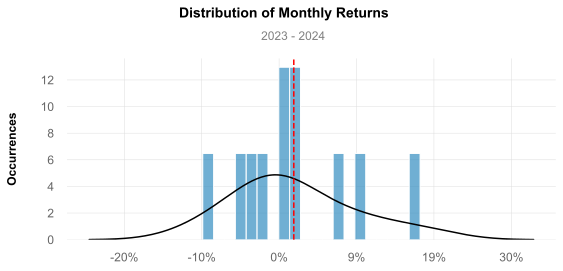

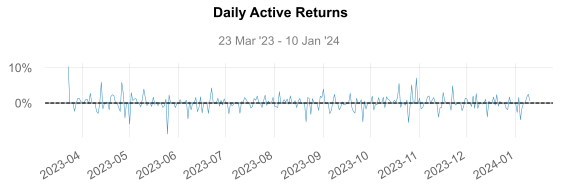

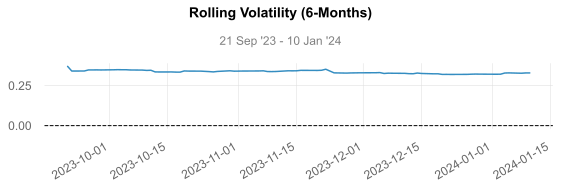

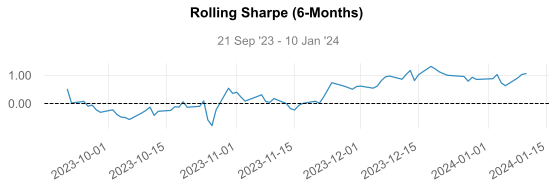

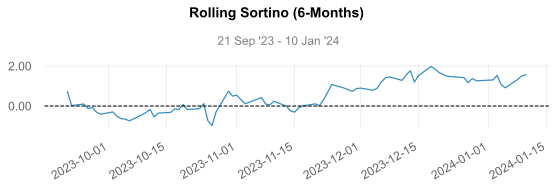

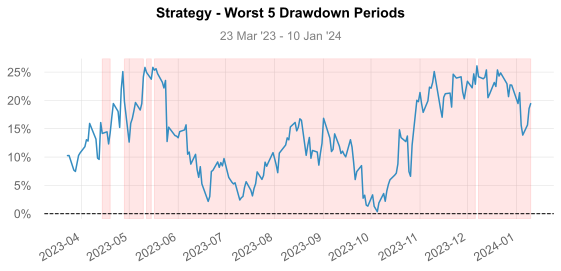

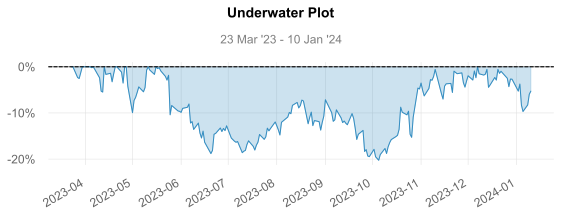

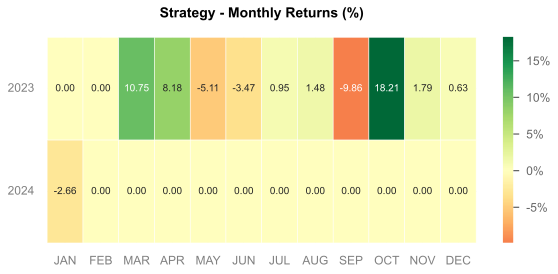

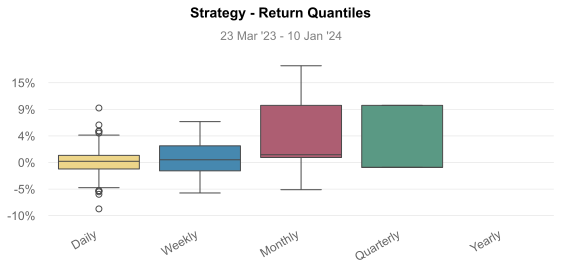

In [36]:
strat_cnn_optimum_print = strat_cnn_optimum.sum(axis=1)
cnn_optimum_daily_returns = strat_cnn_optimum_print.fillna(0)

qs.extend_pandas()
qs.reports.full(cnn_optimum_daily_returns)

The CNN model's performance prior to optimisation shows a fluctuating yet overall declining trajectory in the cumulative returns plot, resulting in a negative performance with a significant drawdown, as evidenced by the performance metrics displaying a negative cumulative return and a Sharpe ratio far below zero.

After the optimisation of weights, the CNN model exhibits a starkly improved performance. The cumulative returns plot now indicates a growth trajectory, and the performance metrics show a positive cumulative return with an enhanced Sharpe ratio above zero. This comparison suggests that the optimisation process contributed significantly to the strategy's effectiveness, successfully transforming a strategy with suboptimal returns into one with a profitable outcome

## LSTM Model Architecture and Training for Asset Return Forecasting
This comprehensive analysis utilises a Long Short-Term Memory (LSTM) network to predict the return rates of various financial assets, employing the Keras library with TensorFlow as the backend. This strategy highlights the use of LSTM, renowned for its efficacy in capturing temporal dependencies in time series data, thus making it particularly suited for financial applications.

# Model Construction:
Initialisation:

A Sequential model structure is employed, facilitating a systematic assembly of layers. This methodical layer-by-layer construction allows for a clear and logical addition of LSTM, dropout, and dense layers.
Core Configuration:

LSTM Layers: Multiple LSTM layers are configured, where each layer is tailored based on the specified number of units and layers. The first LSTM layer explicitly defines the input shape and returns sequences if additional layers are present, allowing for the propagation of temporal information.
Dropout Layers: Conditionally added between LSTM layers to prevent overfitting by randomly omitting units during training, thereby enhancing the model's generalisation ability.
Output Specification:

Concludes with a dense output layer using a linear activation function to predict continuous returns directly, aligning with the regression nature of the task.
# Model Compilation and Optimisation:
Compiling the Model: The model is compiled using the 'adam' optimiser, renowned for its efficiency in handling sparse gradients on noisy problems. The mean squared error (MSE) serves as the loss function, directly aligning with the objective to minimise prediction errors for asset returns.
Custom Metrics: A bespoke accuracy metric, reg_accuracy, is defined to assess predictions within a specified threshold, providing a nuanced measure of prediction quality.
# Systematic Parameter Tuning:
Grid Search: A structured grid search over a predefined range of hyperparameters (LSTM units, number of layers, dropout rates) is conducted to find the optimal model configuration. This rigorous exploration assesses configurations based on both validation loss and accuracy.
Early Stopping: An EarlyStopping callback is employed to cease training when no improvement is observed in the validation loss for a specified number of epochs, thereby optimising computational resources and model performance.
# Training and Evaluation:
Model Training: The LSTM model is trained using historical data, with performance monitored on a validation set to safeguard against overfitting.
Model Evaluation: Post training, the model’s efficacy is quantitatively evaluated on a reserved test set, examining MSE, accuracy, and general prediction performance.
# Practical Application and Performance Optimisation:
Predictive Outputs: Initial predictions are scrutinised to verify model functionality.
Financial Metrics: The model's forecasts are utilised to compute financial metrics like mean squared error and accuracy per asset, facilitating detailed performance analysis.
Portfolio Optimisation: Leveraging the LSTM predictions, portfolio weights are optimised using advanced techniques like the Sharpe ratio maximisation, showcasing the model's practical financial application.
This extensive methodology underlines the application of LSTM networks in financial analytics, demonstrating their profound capability in handling and forecasting complex financial time series data through meticulous model tuning and strategic deployment.

In [37]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from keras.callbacks import EarlyStopping
import keras.backend as K

def reg_accuracy(y_true, y_pred, threshold=0.1):
    return K.mean(K.less_equal(K.abs(y_true - y_pred), threshold), axis=-1)

def build_lstm(input_shape, lstm_units, lstm_layers, dropout_rate, output_units):
    model = Sequential(name='LSTM_Model')
    
    # Add multiple LSTM layers based on the number of layers specified
    for i in range(lstm_layers):
        if i == 0:
            # First LSTM layer needs to specify input_shape and should return sequences if more than one layer is used
            model.add(LSTM(lstm_units, activation='relu', input_shape=input_shape, return_sequences=lstm_layers > 1))
        else:
            # Subsequent LSTM layers only return sequences if they are not the last layer
            model.add(LSTM(lstm_units, activation='relu', return_sequences=i < lstm_layers - 1))
        
        # Add dropout after each LSTM layer if specified
        if dropout_rate > 0:
            model.add(Dropout(dropout_rate))
    
    # Output layer with the number of units equal to the number of output variables
    model.add(Dense(output_units, activation='linear'))

    # Compile the model
    model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mean_squared_error', reg_accuracy])
    
    return model








In [38]:
import itertools
from tensorflow.keras.callbacks import EarlyStopping
import numpy as np
"""
# parameter grid
param_grid = {
    'lstm_units': [64, 128, 256],
    'lstm_layers': [2, 3, 4],
    'dropout_rate': [0.1, 0.2, 0.3, 0.4]
}

best_model = None
best_loss = float('inf')
best_params = {}

# Explore the parameter grid
for params in itertools.product(*param_grid.values()):
     # Extract parameters from param_dict
    lstm_units = param_dict['lstm_units']
    lstm_layers = param_dict['lstm_layers']
    dropout_rate = param_dict['dropout_rate']
    
    param_dict = dict(zip(param_grid.keys(), params))
    print("Testing configuration:", param_dict)

    model = build_lstm(input_shape=(1, len(tickers) * lags), lstm_units=lstm_units, lstm_layers=lstm_layers, dropout_rate=dropout_rate, output_units=len(tickers))
    
    early_stopping_monitor = EarlyStopping(
        monitor='val_loss',
        patience=10,
        verbose=1,
        restore_best_weights=True
    )

    model.fit(
        X_train, y_train,
        epochs=1000,
        batch_size=32,
        validation_data=(X_val, y_val),
        callbacks=[early_stopping_monitor],
        verbose=1
    )

    val_loss = model.evaluate(X_val, y_val, verbose=1)[0]
    
    # Update the best model based on lower loss
    if val_loss < best_loss:
        best_loss = val_loss
        best_model = model
        best_params = param_dict
        print(f"New best model found: {param_dict} with Validation Loss: {val_loss:.4f}")

print(f"Best model parameters: {best_params} with validation loss: {best_loss:.4f}")

# Optionally, evaluate the best model on the test set
test_loss, test_mse, test_accuracy = best_model.evaluate(X_test, y_test, verbose=1)
print(f"Test Loss: {test_loss:.4f}, Test MSE: {test_mse:.4f}, Test Accuracy: {test_accuracy:.4f}")
"""


'\n# parameter grid\nparam_grid = {\n    \'lstm_units\': [64, 128, 256],\n    \'lstm_layers\': [2, 3, 4],\n    \'dropout_rate\': [0.1, 0.2, 0.3, 0.4]\n}\n\nbest_model = None\nbest_loss = float(\'inf\')\nbest_params = {}\n\n# Explore the parameter grid\nfor params in itertools.product(*param_grid.values()):\n     # Extract parameters from param_dict\n    lstm_units = param_dict[\'lstm_units\']\n    lstm_layers = param_dict[\'lstm_layers\']\n    dropout_rate = param_dict[\'dropout_rate\']\n    \n    param_dict = dict(zip(param_grid.keys(), params))\n    print("Testing configuration:", param_dict)\n\n    model = build_lstm(input_shape=(1, len(tickers) * lags), lstm_units=lstm_units, lstm_layers=lstm_layers, dropout_rate=dropout_rate, output_units=len(tickers))\n    \n    early_stopping_monitor = EarlyStopping(\n        monitor=\'val_loss\',\n        patience=10,\n        verbose=1,\n        restore_best_weights=True\n    )\n\n    model.fit(\n        X_train, y_train,\n        epochs=1000,

In [39]:
from keras.callbacks import EarlyStopping
"""
lstm_model = build_lstm(
    input_shape=(1,len(tickers)*lags),  
    lstm_units=best_params['lstm_units'],
    lstm_layers=best_params['lstm_layers'],
    dropout_rate=best_params['dropout_rate'],
    output_units=len(tickers) 
)
"""
# we used assigned parameter insteads to save runing time. Or unhide the above section and use the automation hyperparameter tuning part
lstm_model = build_lstm(
    input_shape=(1,len(tickers)*lags),  
    lstm_units=256,
    lstm_layers=3,
    dropout_rate=0.4,
    output_units=len(tickers)  
)


# Early stopping monitor to prevent overfitting
early_stopping_monitor = EarlyStopping(
    monitor='val_loss', 
    patience=10, 
    restore_best_weights=True,
    verbose=1
)

# Fit the model
history = lstm_model.fit(
    X_train,
    y_train,
    epochs=1000,
    batch_size=32,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping_monitor],
    verbose=1
)

test_loss, test_mse, test_accuracy = lstm_model.evaluate(X_test, y_test, verbose=1)
print(f"Test MSE: {test_mse:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Loss: {test_loss:.4f}") 

Epoch 1/1000
22/22 [==============================] - 4s 38ms/step - loss: 8.9125e-04 - mean_squared_error: 8.9125e-04 - reg_accuracy: 0.9896 - val_loss: 0.0011 - val_mean_squared_error: 0.0011 - val_reg_accuracy: 0.9882
Epoch 2/1000
22/22 [==============================] - 0s 16ms/step - loss: 8.9098e-04 - mean_squared_error: 8.9098e-04 - reg_accuracy: 0.9906 - val_loss: 0.0011 - val_mean_squared_error: 0.0011 - val_reg_accuracy: 0.9906
Epoch 3/1000
22/22 [==============================] - 0s 18ms/step - loss: 8.7688e-04 - mean_squared_error: 8.7688e-04 - reg_accuracy: 0.9906 - val_loss: 0.0011 - val_mean_squared_error: 0.0011 - val_reg_accuracy: 0.9917
Epoch 4/1000
22/22 [==============================] - 0s 17ms/step - loss: 8.8249e-04 - mean_squared_error: 8.8249e-04 - reg_accuracy: 0.9898 - val_loss: 0.0011 - val_mean_squared_error: 0.0011 - val_reg_accuracy: 0.9906
Epoch 5/1000
22/22 [==============================] - 0s 17ms/step - loss: 8.7197e-04 - mean_squared_error: 8.7197e-

In [40]:
lstm_model.save('best_lstm_model.h5')
lstm_pred = lstm_model.predict(X_test)
print(lstm_pred[:5])

7/7 [==============================] - 0s 4ms/step
[[ 0.0007  0.0029  0.0023 -0.0002 -0.0003  0.0004  0.0025]
 [ 0.0018  0.003   0.0023  0.0002  0.0012  0.0021  0.0048]
 [ 0.0005  0.0027  0.0021 -0.0001 -0.0003  0.0006  0.0027]
 [ 0.0005  0.002   0.0018 -0.0007 -0.0002  0.0005  0.003 ]
 [ 0.0011  0.0024  0.0018 -0.0004  0.0005  0.001   0.0028]]


In [41]:
# Squeezing the LSTM predictions removes unnecessary single-dimensional entries from the prediction array, simplifying the data structure for easier handling and integration into DataFrame operations
pred_2d = lstm_pred.squeeze()

predicted_returns = pd.DataFrame(pred_2d, index=prediction_dates, columns=tickers)
predicted_returns.head() 


MSFT   NVDA   AAPL    META    AMZN  GOOGL   TSLA
Date                                                         
2023-03-23 0.0007 0.0029 0.0023 -0.0002 -0.0003 0.0004 0.0025
2023-03-24 0.0018 0.0030 0.0023  0.0002  0.0012 0.0021 0.0048
2023-03-27 0.0005 0.0027 0.0021 -0.0001 -0.0003 0.0006 0.0027
2023-03-28 0.0005 0.0020 0.0018 -0.0007 -0.0002 0.0005 0.0030
2023-03-29 0.0011 0.0024 0.0018 -0.0004  0.0005 0.0010 0.0028

In [42]:
true_returns = data.loc[predicted_returns.index, tickers]

# calculate the MSE
mse = mean_squared_error(true_returns, predicted_returns)
mse

0.0004329078510830507

In [43]:
for ticker in tickers:
    mse = mean_squared_error(true_returns[ticker], predicted_returns[ticker])
    print(f'{ticker}: MSE={mse}')

MSFT: MSE=0.00020600496137585084
NVDA: MSE=0.0007537357130214081
AAPL: MSE=0.0001457703208068858
META: MSE=0.000376024422712058
AMZN: MSE=0.00036861787240141013
GOOGL: MSE=0.000288924872416905
TSLA: MSE=0.0008912767948468375


In [44]:
for ticker in tickers:
    acc = accuracy_score(np.sign(true_returns[ticker]), np.sign(predicted_returns[ticker]))
    print(f'{ticker}: ACC={acc}')

MSFT: ACC=0.5643564356435643
NVDA: ACC=0.5495049504950495
AAPL: ACC=0.5346534653465347
META: ACC=0.46534653465346537
AMZN: ACC=0.5
GOOGL: ACC=0.5099009900990099
TSLA: ACC=0.5198019801980198


In [45]:
strat_lstm = np.sign(predicted_returns) * true_returns[tickers]
strat_lstm.head()

MSFT    NVDA    AAPL    META    AMZN   GOOGL    TSLA
Date                                                              
2023-03-23  0.0195  0.0269  0.0069 -0.0221 -0.0001  0.0213  0.0056
2023-03-24  0.0104 -0.0153  0.0083  0.0084 -0.0059 -0.0015 -0.0095
2023-03-27 -0.0150 -0.0093 -0.0124  0.0155  0.0009 -0.0287  0.0073
2023-03-28 -0.0042 -0.0046 -0.0040  0.0107  0.0082 -0.0141 -0.0138
2023-03-29  0.0190  0.0215  0.0196 -0.0230  0.0305  0.0036  0.0245

In [46]:
strat_lstm.sum().apply(np.exp)

MSFT    1.4998
NVDA    2.0540
AAPL    1.1845
META    0.7721
AMZN    1.0528
GOOGL   1.3255
TSLA    1.2239
dtype: float64

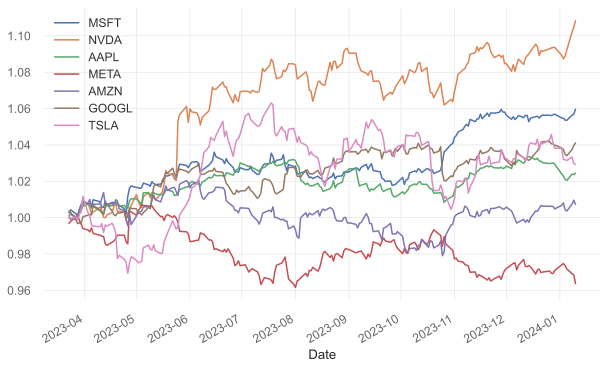

In [47]:
weights = len(tickers) * [1 / len(tickers)]
(weights*strat_lstm).cumsum().apply(np.exp).plot(); 

                           Strategy
-------------------------  ----------
Start Period               2023-03-23
End Period                 2024-01-10
Risk-Free Rate             0.0%
Time in Market             100.0%

Cumulative Return          23.69%
CAGR﹪                     20.07%

Sharpe                     1.63
Prob. Sharpe Ratio         93.01%
Smart Sharpe               1.49
Sortino                    2.56
Smart Sortino              2.33
Sortino/√2                 1.81
Smart Sortino/√2           1.65
Omega                      1.32

Max Drawdown               -9.53%
Longest DD Days            150
Volatility (ann.)          17.15%
Calmar                     2.11
Skew                       0.27
Kurtosis                   2.23

Expected Daily %           0.11%
Expected Monthly %         1.95%
Expected Yearly %          11.22%
Kelly Criterion            13.44%
Risk of Ruin               0.0%
Daily Value-at-Risk        -1.67%
Expected Shortfall (cVaR)  -1.67%

Max Consecutive Wins     

None

Start      Valley         End  Days  Max Drawdown  99% Max Drawdown
1  2023-06-21  2023-10-26  2023-11-17   150       -9.5294           -8.7269
2  2023-04-03  2023-04-25  2023-05-04    32       -6.7994           -6.5427
3  2023-12-28  2024-01-05  2024-01-10    14       -3.2338           -3.1364
4  2023-11-29  2023-12-04  2023-12-14    16       -2.1398           -1.9553
5  2023-05-23  2023-05-24  2023-05-24     2       -2.0215           -1.1444

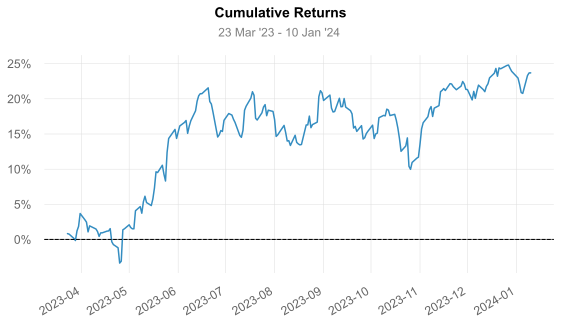

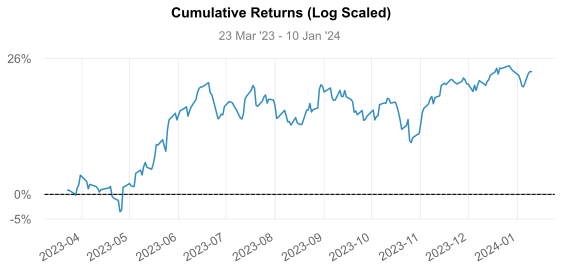

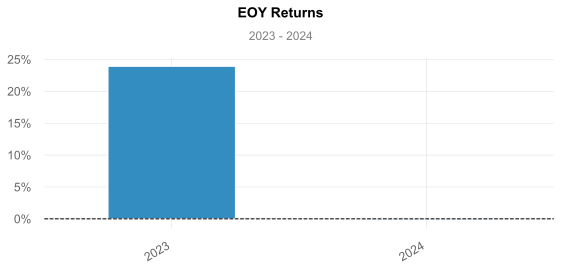

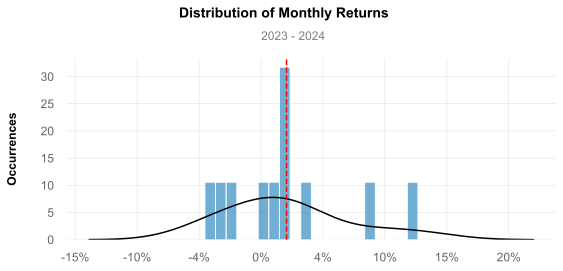

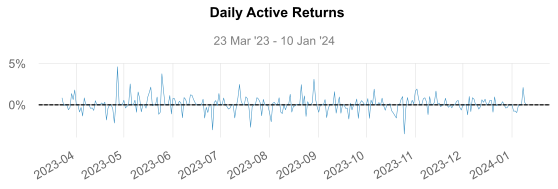

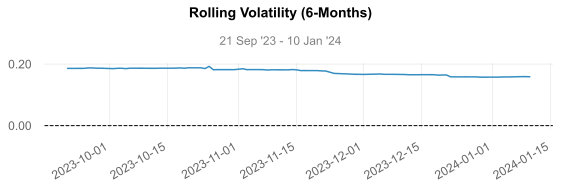

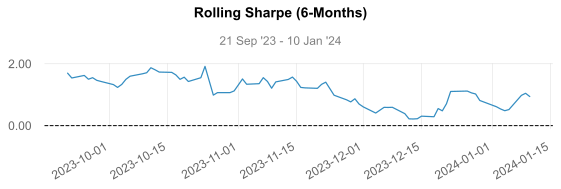

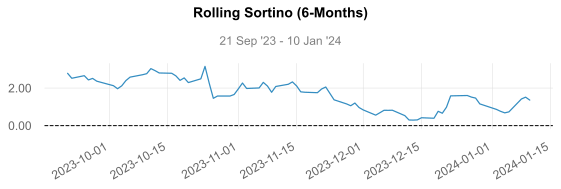

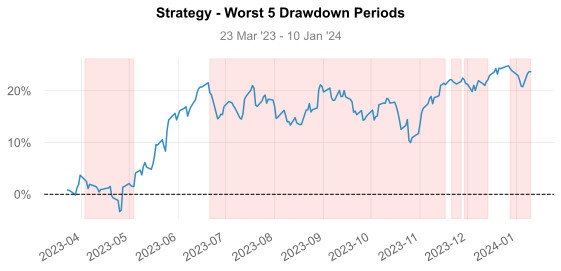

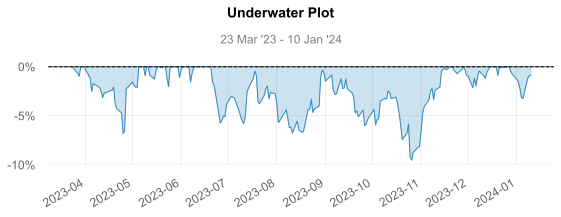

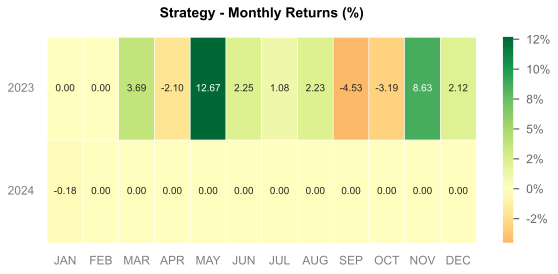

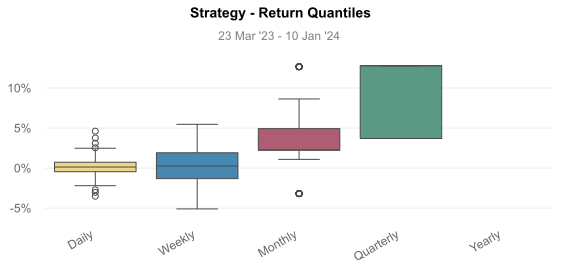

In [48]:
lstm_portfolio_cumulative_returns = (strat_lstm*weights).sum(axis=1)
lstm_daily_returns = lstm_portfolio_cumulative_returns.fillna(0)

qs.extend_pandas()
qs.reports.full(lstm_daily_returns)

The LSTM model with average-weighted method demonstrates a positive outcome over the selected period, as indicated by the uptrend in the cumulative returns graph. This performance is underscored by a favorable Sharpe ratio, which suggests that the returns were obtained with a reasonable amount of risk. Additionally, the win rates for days, months, quarters, and the year are above 50%, indicating a high proportion of profitable periods. Despite some volatility, as shown by the rolling volatility graph, the strategy appears to have navigated the market conditions effectively, maintaining a stable upward trend in returns. The positive skew in the distribution of monthly returns also points to more frequent and higher gains compared to losses. Overall, the LSTM's performance metrics depict a strategy that has largely succeeded in securing gains over time, though it's not without periods of drawdowns and underperformance.

In [49]:
from scipy.optimize import minimize

bnds = len(tickers) * [(-1, 1)]
cons = {'type': 'eq', 'fun': lambda weights: weights.sum() - 1}

In [50]:
w_lstm = predicted_returns.copy()


In [51]:
def sharpe(weights, r, re):
    port_ret = np.dot(r, weights)
    port_vol = portfolio_volatility(weights, re)
    return port_ret / port_vol

In [52]:
%%time
for pred in predicted_returns.iloc[:].iterrows():
    r = pred[1].values * 252
    re = predicted_returns.loc[:pred[0]][tickers]
    opt = minimize(lambda w_lstm: -sharpe(w_lstm, r=r, re=re),
                  np.ones(len(tickers)), bounds=bnds,
                         constraints=cons)
    w_lstm.loc[pred[0]] = opt['x']

opt['x']

CPU times: total: 5.69 s
Wall time: 8.16 s


array([ 0.0512,  1.    ,  0.9921, -0.2156, -0.263 , -1.    ,  0.4353])

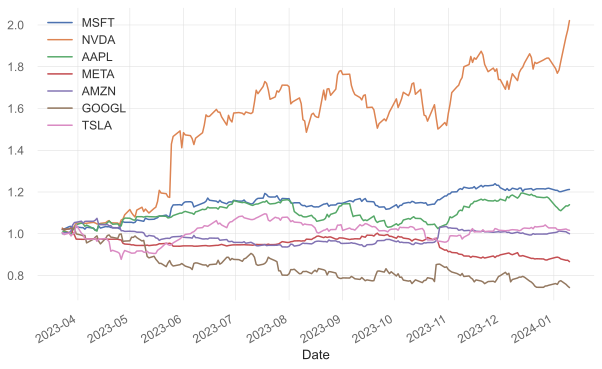

In [53]:
strat_lstm_optimum = w_lstm * true_returns.loc[w_lstm.index[0]:][tickers]
strat_lstm_optimum.dropna(inplace=True)


strat_lstm_optimum.cumsum().apply(np.exp).plot(label='Portfolio')
plt.legend(); 

                           Strategy
-------------------------  ----------
Start Period               2023-03-23
End Period                 2024-01-10
Risk-Free Rate             0.0%
Time in Market             100.0%

Cumulative Return          65.0%
CAGR﹪                     53.83%

Sharpe                     1.47
Prob. Sharpe Ratio         92.12%
Smart Sharpe               1.3
Sortino                    2.61
Smart Sortino              2.32
Sortino/√2                 1.85
Smart Sortino/√2           1.64
Omega                      1.31

Max Drawdown               -36.16%
Longest DD Days            176
Volatility (ann.)          51.16%
Calmar                     1.49
Skew                       1.71
Kurtosis                   10.09

Expected Daily %           0.25%
Expected Monthly %         4.66%
Expected Yearly %          28.45%
Kelly Criterion            11.95%
Risk of Ruin               0.0%
Daily Value-at-Risk        -5.0%
Expected Shortfall (cVaR)  -5.0%

Max Consecutive Wins       

None

Start      Valley         End  Days  Max Drawdown  99% Max Drawdown
1  2023-07-19  2023-10-20  2024-01-10   176      -36.1642          -34.5125
2  2023-04-03  2023-05-12  2023-05-24    52      -22.0973          -21.3738
3  2023-06-21  2023-06-26  2023-06-29     9       -6.3519           -4.0203
4  2023-05-31  2023-05-31  2023-05-31     1       -3.9652               NaN
5  2023-06-05  2023-06-06  2023-06-07     3       -3.5009           -2.9578

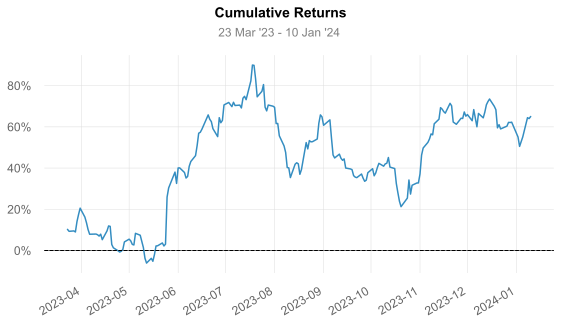

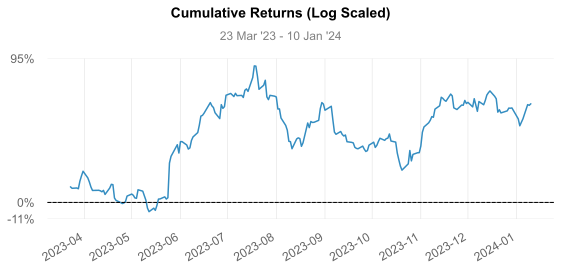

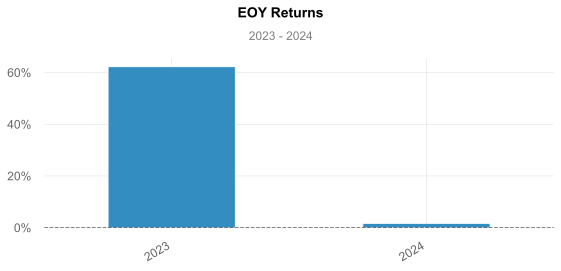

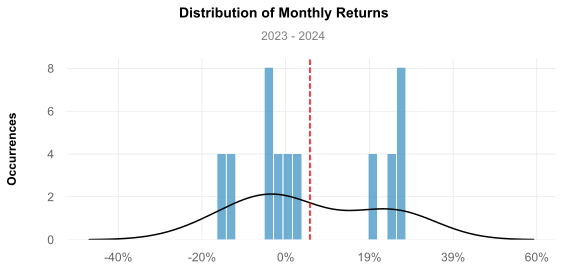

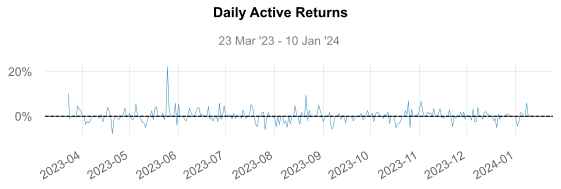

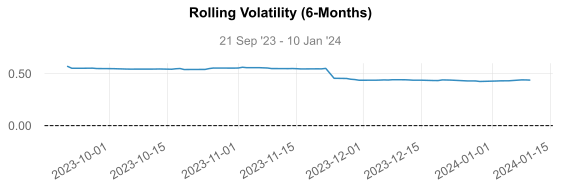

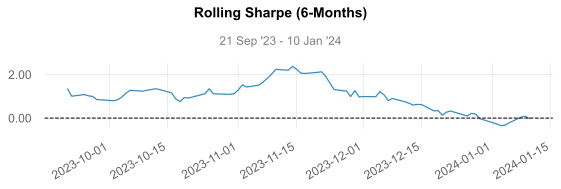

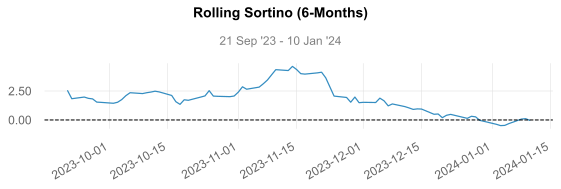

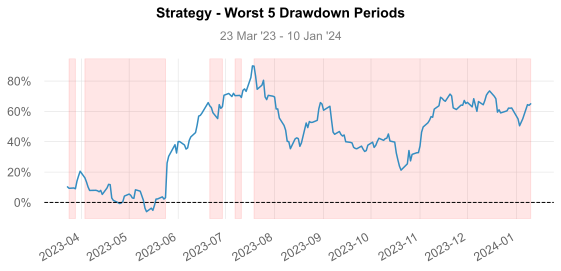

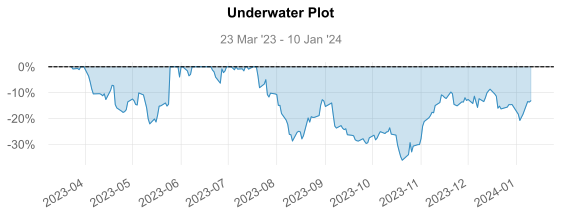

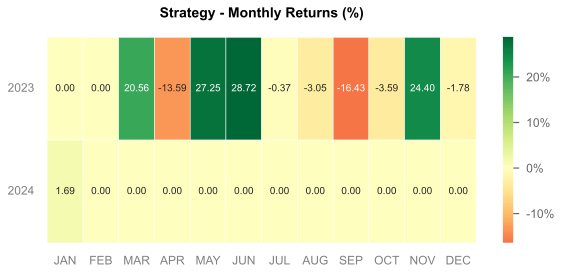

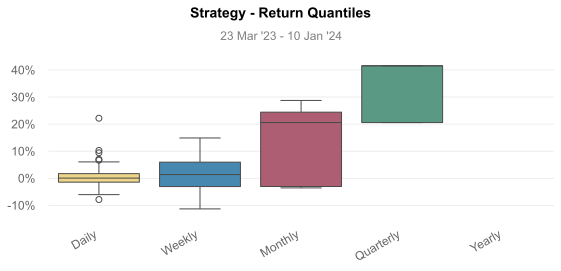

In [54]:



strat_lstm_optimum_print = strat_lstm_optimum.sum(axis=1)
# calculate daily return
lstm_optimum_daily_returns = strat_lstm_optimum_print.fillna(0)


qs.extend_pandas()

# generate the report
qs.reports.full(lstm_optimum_daily_returns)

The LSTM's improved performance can be attributed to its architecture, which is adept at processing sequences and time-series data. Unlike CNNs, which excel in identifying spatial hierarchies in data, LSTMs are designed to remember long-term dependencies, making them more suitable for financial time series where past information is critical for predicting future trends.

LSTMs can capture the temporal order and the potential cause-and-effect relationships within the sequence of market movements. This characteristic is particularly advantageous in financial markets, where previous price actions and patterns can influence future prices. The optimisation process for the LSTM, which likely involved tuning hyperparameters such as the number of layers, units, and dropout rates, could have further enhanced its ability to model the complexities of the market, leading to superior risk-adjusted returns as indicated by the Sharpe ratio, and more robust performance across various time frames.

This temporal dynamic modeling capacity could explain why the LSTM's performance was notably better than that of the CNN. The latter, while powerful in its own right, may not inherently consider the order of data points, which is a critical aspect of financial time series forecasting.

## TCN Model Architecture and Implementation for Asset Return Forecasting
This comprehensive analysis leverages a Temporal Convolutional Network (TCN) to predict the return rates of various financial assets. Utilising the Keras library with TensorFlow backend, this approach incorporates advanced deep learning techniques tailored for the complexities of time series forecasting in finance.

# Model Construction:
Initialisation:

A Model from Keras is structured using a functional API, which allows for flexible and powerful model architectures. The TCN model is particularly designed to capture temporal hierarchies and long-range dependencies, making it exceptionally suited for time series data like stock returns.
Core Configuration:

Convolutional Layers: The model includes multiple convolutional layers with specified numbers of filters, kernel sizes, and dilation rates. These layers are configured to process data sequentially, ensuring no future leakage and maintaining causality.
Dropout and Batch Normalisation: Dropout layers are interspersed among convolutional layers to prevent overfitting by randomly omitting units during training. Batch normalisation is employed to stabilise and accelerate the learning process.
Output Specification:

Culminates with a dense output layer with linear activation to predict continuous asset returns, aligning with the regression nature of the task.
# Model Compilation:
Optimisation and Loss Function: The model is compiled using the 'adam' optimiser for efficient learning and mean squared error (MSE) as the loss function to minimise prediction errors directly related to financial returns.
Custom Metrics: A bespoke metric, reg_accuracy, assesses prediction accuracy within a specified threshold, providing nuanced insights into model performance beyond traditional loss metrics.
#  Parameter Tuning and Model Training:
Parameter Grid Search: Executes a structured exploration across a predefined grid of hyperparameters (number of filters, kernel sizes, dilation patterns, and dropout rates) to find the optimal configuration. This process assesses each model based on validation loss and custom accuracy metrics.
Early Stopping Mechanism: An EarlyStopping callback monitors validation loss to halt training optimally when no improvement is noted, enhancing computational efficiency and preventing overfitting.
# Training Execution and Evaluation:
Training Process: The model is trained using historical data, with performance metrics monitored on a validation set to ensure generalisation.
Evaluation and Optimisation: Post-training, the model's efficacy is quantitatively evaluated on a test set, examining MSE, custom accuracy, and general loss metrics.
# Practical Application and Portfolio Optimisation:
Predictive Performance: Initial predictions are scrutinised to confirm the model's operational efficacy.
Financial Metrics: Utilises the model's forecasts to compute MSE and custom accuracy for each asset, facilitating a comprehensive performance analysis.
Advanced Portfolio Strategies: Predictions are further employed to optimise portfolio weights using techniques like Sharpe ratio maximisation, showcasing the practical financial application of the TCN model in real-world scenarios.
This methodology underscores the utilisation of TCN models in financial analytics, highlighting their capacity to manage and predict complex financial time series data through meticulous model tuning and strategic deployment. This structured approach ensures that the model is not only statistically robust but also practically relevant in financial decision-making contexts.

In [58]:
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model
from tcn import TCN  # Ensure TCN is imported 
import tensorflow.keras.backend as K

def reg_accuracy(y_true, y_pred, threshold=0.1):
    # Define a custom accuracy metric for regression models within a specified threshold
    return K.mean(K.less_equal(K.abs(y_true - y_pred), threshold), axis=-1)

def build_tcn(input_shape, nb_filters, kernel_size, dilations, dropout_rate, output_dim):
    # Create input layer with the given input shape
    input_layer = Input(shape=input_shape)
    
    # Configure the TCN layer with specified parameters and relu activation
    tcn_layer = TCN(nb_filters=nb_filters, kernel_size=kernel_size, dilations=dilations,
                    padding='causal', dropout_rate=dropout_rate,
                    return_sequences=False, activation='relu')(input_layer)
    
    # Add a dense output layer with linear activation
    output_layer = Dense(output_dim, activation='linear')(tcn_layer)
    
    # Create the model by specifying inputs and outputs
    model = Model(inputs=input_layer, outputs=output_layer)
    
    # Compile the model with Mean Squared Error loss and a custom accuracy metric
    model.compile(optimizer='adam', loss='mse', metrics=['mse', reg_accuracy])
    return model

 


In [56]:
import itertools
from tensorflow.keras.callbacks import EarlyStopping
import numpy as np
"""

param_grid = {
    'nb_filters': [32, 64, 128, 256],
    'kernel_size': [2, 3, 4],
    'dilations': [[1, 2, 4], [2, 4, 8]],
    'dropout_rate': [0.2, 0.3, 0.4]
}

best_model = None
best_loss = float('inf')
best_params = {}

# Explore the parameter grid
for params in itertools.product(*param_grid.values()):
    param_dict = dict(zip(param_grid.keys(), params))
    print("Testing configuration:", param_dict)

    try:
        tcn_model = build_tcn(input_shape=(1, len(tickers) * lags), nb_filters=param_dict['nb_filters'], 
                              kernel_size=param_dict['kernel_size'], dilations=param_dict['dilations'], 
                              dropout_rate=param_dict['dropout_rate'], output_dim=7)
        early_stopping_monitor = EarlyStopping(
            monitor='val_loss',
            patience=10,
            verbose=1,
            restore_best_weights=True
        )

        tcn_model.fit(
            X_train, y_train,
            epochs=1000,
            batch_size=32,
            verbose=1,
            validation_data=(X_val, y_val),
            callbacks=[early_stopping_monitor]
        )

        # Evaluate the model
        val_loss = tcn_model.evaluate(X_val, y_val, verbose=1)[0]
        
        # Update the best model based on lower loss only
        if val_loss < best_loss:
            best_loss = val_loss
            best_model = tcn_model
            best_params = param_dict
            print(f"New best model found: {param_dict} with Validation Loss: {val_loss:.4f}")
    except Exception as e:
        print(f"Failed to build or train model with parameters {param_dict} due to error: {e}")

print(f"Best model parameters: {best_params} with validation loss: {best_loss:.4f}")
"""


'\n\nparam_grid = {\n    \'nb_filters\': [32, 64, 128, 256],\n    \'kernel_size\': [2, 3, 4],\n    \'dilations\': [[1, 2, 4], [2, 4, 8]],\n    \'dropout_rate\': [0.2, 0.3, 0.4]\n}\n\nbest_model = None\nbest_loss = float(\'inf\')\nbest_params = {}\n\n# Explore the parameter grid\nfor params in itertools.product(*param_grid.values()):\n    param_dict = dict(zip(param_grid.keys(), params))\n    print("Testing configuration:", param_dict)\n\n    try:\n        tcn_model = build_tcn(input_shape=(1, len(tickers) * lags), nb_filters=param_dict[\'nb_filters\'], \n                              kernel_size=param_dict[\'kernel_size\'], dilations=param_dict[\'dilations\'], \n                              dropout_rate=param_dict[\'dropout_rate\'], output_dim=7)\n        early_stopping_monitor = EarlyStopping(\n            monitor=\'val_loss\',\n            patience=10,\n            verbose=1,\n            restore_best_weights=True\n        )\n\n        tcn_model.fit(\n            X_train, y_train,\n

In [59]:
# Step 1: Build the optimal TCN model using best_params
"""
tcn_model = build_tcn(
    input_shape=(1, len(tickers) * lags),
    nb_filters=best_params['nb_filters'],
    kernel_size=best_params['kernel_size'],
    dilations=best_params['dilations'],
    dropout_rate=best_params['dropout_rate'],
    output_dim=len(tickers)
)
"""
tcn_model = build_tcn(
    input_shape=(1, len(tickers) * lags),
    nb_filters=64,
    kernel_size=2,
    dilations=[1,2,4],
    dropout_rate=0.4,
    output_dim=len(tickers)
)


# Fit the model on the training data
early_stopping_monitor = EarlyStopping(
    monitor='val_loss',
    patience=10,
    verbose=1,
    restore_best_weights=True
)

tcn_model.fit(
    X_train, y_train,
    epochs=1000,
    batch_size=32,
    verbose=1,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping_monitor]
)

# Make predictions
tcn_pred = tcn_model.predict(X_test)

# evaluate the model on the test set
test_loss, test_mse, test_accuracy = tcn_model.evaluate(X_test, y_test, verbose=1)
print(f"Test Loss: {test_loss:.4f}, Test MSE: {test_mse:.4f}, Test Accuracy: {test_accuracy:.4f}")


Epoch 1/1000
22/22 [==============================] - 2s 23ms/step - loss: 4.5092 - mse: 4.5092 - reg_accuracy: 0.0608 - val_loss: 0.4561 - val_mse: 0.4561 - val_reg_accuracy: 0.1665
Epoch 2/1000
22/22 [==============================] - 0s 8ms/step - loss: 1.4473 - mse: 1.4473 - reg_accuracy: 0.0935 - val_loss: 0.2421 - val_mse: 0.2421 - val_reg_accuracy: 0.2349
Epoch 3/1000
22/22 [==============================] - 0s 8ms/step - loss: 0.9527 - mse: 0.9527 - reg_accuracy: 0.1110 - val_loss: 0.1725 - val_mse: 0.1725 - val_reg_accuracy: 0.2645
Epoch 4/1000
22/22 [==============================] - 0s 7ms/step - loss: 0.7752 - mse: 0.7752 - reg_accuracy: 0.1329 - val_loss: 0.1392 - val_mse: 0.1392 - val_reg_accuracy: 0.2715
Epoch 5/1000
22/22 [==============================] - 0s 8ms/step - loss: 0.5723 - mse: 0.5723 - reg_accuracy: 0.1433 - val_loss: 0.1095 - val_mse: 0.1095 - val_reg_accuracy: 0.3011
Epoch 6/1000
22/22 [==============================] - 0s 8ms/step - loss: 0.4207 - mse: 0

KeyboardInterrupt: 

In [ ]:
tcn_model.save('best_tcn_model.h5')
tcn_pred = tcn_model.predict(X_test)
print(tcn_pred[:5])

In [ ]:

prediction_dates = data.index[-len(tcn_pred):] 

# Create a DataFrame for the predictions
predicted_returns = pd.DataFrame(tcn_pred, index=prediction_dates, columns=tickers)




In [ ]:
predicted_returns.info()

In [ ]:
true_returns = data.loc[predicted_returns.index, tickers]

# calculate the MSE
mse = mean_squared_error(true_returns, predicted_returns)
mse

In [ ]:
for ticker in tickers:
    mse = mean_squared_error(true_returns[ticker], predicted_returns[ticker])
    print(f'{ticker}: MSE={mse}')

In [ ]:
for ticker in tickers:
    acc = accuracy_score(np.sign(true_returns[ticker]), np.sign(predicted_returns[ticker]))
    print(f'{ticker}: ACC={acc}')

In [ ]:
strat_tcn = np.sign(predicted_returns) * true_returns[tickers]
strat_tcn.head()

In [ ]:
strat_tcn.sum().apply(np.exp)

In [ ]:
weights = len(tickers) * [1 / len(tickers)]
(weights*strat_tcn).cumsum().apply(np.exp).plot(); 

In [ ]:
import quantstats as qs

tcn_portfolio_cumulative_returns = (strat_tcn*weights).sum(axis=1)
tcn_daily_returns = tcn_portfolio_cumulative_returns.fillna(0)
qs.extend_pandas()
qs.reports.full(tcn_daily_returns)

The performance of the TCN model with equal weighting is quite positive over the observed period, as evidenced by a notable cumulative return and a Compound Annual Growth Rate (CAGR) that suggests robust annual growth. A Sharpe ratio greater than one indicates that the risk-adjusted returns are favorable when compared to a risk-free investment. The rolling volatility chart reflects controlled risk levels, implying stable performance. This performance demonstrates the model’s effectiveness in leveraging patterns in time-series data to predict stock movements.

In [ ]:
bnds = len(tickers) * [(-1, 1)]
cons = {'type': 'eq', 'fun': lambda weights: weights.sum() - 1}

In [ ]:
w_tcn = predicted_returns.copy()



In [ ]:
def sharpe(weights, r, re):
    port_ret = np.dot(r, weights)
    port_vol = portfolio_volatility(weights, re)
    return port_ret / port_vol

In [ ]:
%%time
for pred in predicted_returns.iloc[:].iterrows():
    r = pred[1].values * 252
    re = predicted_returns.loc[:pred[0]][tickers]
    opt = minimize(lambda w_tcn: -sharpe(w_tcn, r=r, re=re),
                  np.ones(len(tickers)), bounds=bnds,
                         constraints=cons)
    w_tcn.loc[pred[0]] = opt['x']

opt['x']

In [ ]:
strat_tcn_optimum = w_tcn * true_returns.loc[w_tcn.index[0]:][tickers]
strat_tcn_optimum.dropna(inplace=True)


strat_tcn_optimum.cumsum().apply(np.exp).plot(label='Portfolio')
plt.legend(); 

In [ ]:
strat_tcn_optimum_print = strat_tcn_optimum.sum(axis=1)

tcn_optimum_daily_returns = strat_tcn_optimum_print.fillna(0)

qs.extend_pandas()

qs.reports.full(tcn_optimum_daily_returns)

The TCN model with equal weighting demonstrated an encouraging performance, reflecting a significant positive cumulative return. The Sharpe ratio exceeded unity, denoting a reward exceeding the risk-free rate when considering the volatility of the returns. Despite a notable maximum drawdown, the model's resilience is evident in the high win rates across daily, monthly, and quarterly periods.

When set against other algorithms post-optimisation, the TCN's balanced approach has arguably capitalised on its inherent strengths in discerning temporal patterns within the data — a trait that's particularly valuable for time series forecasting like stock prices. The augmented cumulative returns and consistent win rates suggest the TCN model’s enhanced proficiency in trend detection and prediction, marking a superior performance relative to the CNN and LSTM models under similar weighting strategies.

Optimisation of the LSTM model seems to have bolstered its capability to interpret and predict the long-range dependencies present in stock price movements, which might account for its advanced performance over the unoptimised version. The notable leap in win rates and cumulative returns post-optimisation intimates that the model has successfully harnessed its memory cells to gain deeper insights into the market data's temporal sequences.

Conversely, the CNN’s core expertise in feature extraction, particularly within spatial data, may not have been as effective due to the temporal nature of the dataset. Despite the equal weighting, the architecture of the CNN might not have been optimally configured to capture the sequential dependencies in the stock price data, potentially leading to its subdued performance compared to the LSTM and TCN models that specialise in processing sequential information.

The disparity in the performance among these models underscores the pivotal role of model selection in harmony with the data’s characteristics and the forecasting task. It also highlights how optimising model weights can substantially enhance a model's predictive accuracy, as shown by the improved metrics after optimisation. The LSTM and TCN, with their respective aptitudes for temporal analysis, appear especially well-suited for financial time series forecasting tasks.

## Ensemble Method Utilising Bayesian Model Averaging for Financial Predictions
This ensemble methodology combines predictions from Convolutional Neural Network (CNN), Long Short-Term Memory (LSTM), and Temporal Convolutional Network (TCN) models to forecast financial returns more accurately. By firstly employing Bayesian Model Averaging (BMA), the method leverages the strengths of each model based on their predictive likelihood, calculated from the inverse of their mean squared errors (MSE). And we also employed the optimisation later for comparation.

# Model Integration and Weight Calculation:
Prediction and Error Calculation:
Each model (CNN, LSTM, TCN) generates predictions for the asset returns.
The MSE for each model is calculated by comparing its predictions against the actual test data.
Likelihood Estimation:
The likelihood of each model being the best model given the data is estimated as the reciprocal of its MSE. This likelihood represents the model's ability to predict the data accurately, assuming lower error equates to higher probability of correctness.
Weight Determination:
Weights for each model's predictions are determined proportionally to their likelihoods, ensuring that models with lower errors (higher likelihoods) have a greater influence on the final ensemble prediction.
Ensemble Prediction:
The final predictions are a weighted average of the predictions from the individual models, using the weights calculated from their likelihoods.
# Application to Financial Data:
Predictive Output: The ensemble model outputs the combined predictions, which are then structured into a DataFrame aligned with the original financial data's dates.
Performance Evaluation: The overall MSE for the ensemble prediction is computed against true returns to quantify its accuracy.
Strategic Insights: Signs of the predicted returns are used to simulate trading strategies, illustrating the practical application and effectiveness of the ensemble approach in financial markets.
# Portfolio Optimisation:
Sharpe Ratio Maximisation: Using the ensemble predictions, portfolio weights are optimised to maximise the Sharpe ratio, a common measure of risk-adjusted return. This involves solving an optimisation problem where the objective function is the negative of the Sharpe ratio.
Constraint Handling: The optimisation ensures that the sum of the weights equals one, allowing for a fully invested portfolio which can include short selling as indicated by the bounds set on the weights.
# Visualisation and Reporting:
Cumulative Returns Plotting: The cumulative returns of the optimised portfolio are plotted, providing a visual representation of the growth of an investment over time.
Statistical Reporting: Using the quantstats library, a comprehensive report of the portfolio's performance metrics, including daily returns, volatility, and Sharpe ratio, is generated.
This ensemble approach using Bayesian Model Averaging provides a robust framework for financial forecasting. By integrating multiple predictive models, it leverages diverse patterns and signals captured by different architectures, resulting in improved prediction accuracy and reliability. The methodology not only highlights the effectiveness of ensemble techniques in enhancing predictive performance but also demonstrates their practical utility in dynamic and uncertain environments like financial markets.

In [ ]:
# Squeeze the LSTM predictions to remove dimensions of size 1
lstm_pred_squeezed = np.squeeze(lstm_pred)

# Calculate the mean squared error (MSE) for each model's predictions
mse_cnn = np.mean((cnn_pred - y_test) ** 2)
mse_lstm = np.mean((lstm_pred_squeezed - y_test) ** 2)
mse_tcn = np.mean((tcn_pred - y_test) ** 2)

# Calculate the likelihood for each model's predictions (inverse of MSE)
likelihood_cnn = 1 / mse_cnn
likelihood_lstm = 1 / mse_lstm
likelihood_tcn = 1 / mse_tcn

# Calculate the total likelihood (sum of individual likelihoods)
total_likelihood = likelihood_cnn + likelihood_lstm + likelihood_tcn

# Calculate the weight of each model based on its likelihood
weight_cnn = likelihood_cnn / total_likelihood
weight_lstm = likelihood_lstm / total_likelihood
weight_tcn = likelihood_tcn / total_likelihood

# Calculate the ensemble prediction using weighted average of individual model predictions
ensemble_pred = (weight_cnn * cnn_pred + weight_lstm * lstm_pred_squeezed + weight_tcn * tcn_pred)



In [ ]:
prediction_dates = data.index[-len(ensemble_pred):] 

# Create a DataFrame for the predictions
predicted_returns = pd.DataFrame(ensemble_pred, index=prediction_dates, columns=tickers)

predicted_returns.head()

In [ ]:
true_returns = data.loc[predicted_returns.index, tickers]

# calculate the MSE
mse = mean_squared_error(true_returns, predicted_returns)
mse

In [ ]:
for ticker in tickers:
    mse = mean_squared_error(true_returns[ticker], predicted_returns[ticker])
    print(f'{ticker}: MSE={mse}')

In [ ]:
strat_ensemble = np.sign(predicted_returns) * true_returns[tickers]
strat_ensemble.head()

In [ ]:
strat_ensemble.sum().apply(np.exp)

In [ ]:
weights = len(tickers) * [1 / len(tickers)]
(weights*strat_ensemble).cumsum().apply(np.exp).plot(); 

In [ ]:

ensemble_portfolio_cumulative_returns = (strat_ensemble*weights).sum(axis=1)
ensemble_daily_returns = ensemble_portfolio_cumulative_returns.fillna(0)

qs.extend_pandas()
qs.reports.full(ensemble_daily_returns)

The performance of the ensemble method, which applies optimised weights through the BMA algorithm to the CNN, LSTM, and TCN models. The ensemble approach using the BMA method has underperformed compared to the individual CNN, LSTM, and TCN models. This strategy's negative cumulative return and a significantly low Sharpe ratio suggest that the risk-adjusted returns are not only below the risk-free rate but also indicate substantial underperformance. The negative Sortino ratios further imply that the returns do not compensate adequately for the downside volatility experienced. 

In [ ]:
from scipy.optimize import minimize

bnds = len(tickers) * [(-1, 1)]
cons = {'type': 'eq', 'fun': lambda weights: weights.sum() - 1}

In [ ]:
def sharpe(weights, r, re):
    port_ret = np.dot(r, weights)
    port_vol = portfolio_volatility(weights, re)
    return port_ret / port_vol

In [ ]:
%%time
w_ensemble = predicted_returns.copy()


for pred in predicted_returns.iloc[:].iterrows():
    r = pred[1].values * 252
    re = predicted_returns.loc[:pred[0]][tickers]
    opt = minimize(lambda w_ensemble : -sharpe(w_ensemble, r=r, re=re),
                  np.ones(len(tickers)), bounds=bnds,
                         constraints=cons)
    w_ensemble.loc[pred[0]] = opt['x']

opt['x']

In [ ]:
strat_ensemble_optimum=w_ensemble*true_returns.loc[w_ensemble.index[0]:][tickers]
strat_ensemble_optimum.dropna(inplace=True)


strat_ensemble_optimum.cumsum().apply(np.exp).plot(label='Portfolio')
plt.legend(); 

In [ ]:
strat_ensemble_optimum_print= strat_ensemble_optimum.sum(axis=1)
ensemble_optimum_daily_returns = strat_ensemble_optimum_print.fillna(0)

qs.extend_pandas()
qs.reports.full(ensemble_optimum_daily_returns)

The performance of the ensemble method, which applies optimised weights to the CNN, LSTM, and TCN models, shows a distinctive fusion of their individual attributes. The method accrued a cumulative return of 14.82% and a Compound Annual Growth Rate (CAGR) of 12.62%, reflecting a somewhat effective strategy across the observed timeframe. The Sharpe ratio, at 0.65, denotes reasonable risk-adjusted returns, albeit not as robust as one might discern from the individual performances of LSTM or TCN models, which typically excel in recognising and leveraging trends.

A principal advantage of the ensemble approach is the diversification it introduces, reducing dependency on the predictive prowess of a sole model and potentially alleviating the volatility and significant downturns that singular models might experience. Yet, this comes with a compromise; the noted maximum drawdown of -28.98% indicates that while overarching volatility is moderated, substantial risks are still present, possibly dampening the higher yields that individual strategies might achieve under favourable market conditions.

The consistency of the win rates across days, months, quarters, and the year, all surpassing the 50% mark, suggests a level of reliability. However, these rates may not mirror the high points that individual models could reach during peak performance spells. Fundamentally, the ensemble method seems to offer a middle ground, softening the blow of negative extremes but also potentially curtailing maximum profit scenarios. This approach, therefore, serves as a double-edged sword; it could provide a safeguard during downturns but may also limit the gains during uptrends.

# Conclusion
To encapsulate, the application of CNN, LSTM, and TCN models to the financial time series forecasting has rendered varying results, each model bringing its own strengths and weaknesses to the fore. The CNN, known for its prowess in feature extraction from spatial representations, didn't perform as expected, potentially due to the less spatially correlated nature of financial data. 

LSTM's ability to capture long-term dependencies in time series data seemed to have translated well into higher cumulative returns, indicating its suitability for financial forecasting where trend detection is key.

The TCN, with its architectural advantages for handling sequences, demonstrated substantial returns, highlighting the benefits of combining convolutional processes with temporal data. This suggests that temporal convolutional layers can indeed capture pertinent features in time series financial data effectively.

An ensemble method,to combine these models, attempted to leverage their collective strengths. It offered moderate success by balancing out the risks and returns, suggesting that no single model consistently outperformed the others across all metrics. This indicates that while the ensemble method can provide a more balanced performance, it may not always capture the full potential of each individual model during optimal conditions.

